In [43]:
# https://www.kaggle.com/code/pr4nav101/phishing-website-detection-cnn-lstm

import numpy as np 
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')

from keras import Sequential

import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import tree
from colorama import Fore  #Colorama is a module to color the python outputs
from urllib.parse import urlparse

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

# 現在我們可以建立我們的模型。我們將使用一個簡單的LSTM模型。
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simhoz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
df = pd.read_csv('./dataset/dataset_mendeley_fullset.csv')
df.head(20)

,url,website_links,anchor_url,request_url,email_submission,different_href_urls,right_click_disabled,popup_window_text_fields,iframe_redirection,favicon_external_domain,number_of_forms,number_of_forms_with_get_method,number_of_forms_with_post_method,number_of_applet,number_of_embed,number_of_frame,number_input_password,result
0,http://intego3.info/EXEL/index.php,3,0,4,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1,https://www.investopedia.com/terms/n/next-elev...,52,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0
2,https://jobs.emss.org.uk/lcc.aspx,39,5,12,0,0,0,0,1,0,1,0,1,0,0,0,0,0
3,http://www.pracspedia.com/INS/one-time-passwor...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,https://paribas-biznesplanet-logowanie.com,8,0,1,0,0,0,0,1,0,3,0,0,0,0,0,0,1
5,http://intego3.info/EXEL/index.php,3,0,4,0,0,0,0,0,0,1,0,1,0,0,0,0,1
6,https://www.investopedia.com/terms/n/next-elev...,52,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0
7,https://jobs.emss.org.uk/lcc.aspx,39,5,12,0,0,0,0,1,0,1,0,1,0,0,0,0,0
8,http://www.pracspedia.com/INS/one-time-passwor...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,https://paribas-biznesplanet-logowanie.com,8,0,1,0,0,0,0,1,0,3,0,0,0,0,0,0,1


In [48]:
count_pos = df[df['result'] == 1].shape[0]
count_neg = df[df['result'] == 0].shape[0]
print(f"count_pos:{count_pos} count_neg:{count_neg}")

count_pos:21579 count_neg:35953


In [4]:
df['url_len'] = df['url'].apply(lambda x: len(str(x)))


def process_tld(url):
    try:
        # Extract the top level domain (TLD) from the URL given
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

df['domain'] = df['url'].apply(lambda i: process_tld(i))
df.head(20)

,url,website_links,anchor_url,request_url,email_submission,different_href_urls,right_click_disabled,popup_window_text_fields,iframe_redirection,favicon_external_domain,number_of_forms,number_of_forms_with_get_method,number_of_forms_with_post_method,number_of_applet,number_of_embed,number_of_frame,number_input_password,result,url_len,domain
0,http://intego3.info/EXEL/index.php,3,0,4,0,0,0,0,0,0,1,0,1,0,0,0,0,1,34,intego3.info
1,https://www.investopedia.com/terms/n/next-elev...,52,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,52,www.investopedia.com
2,https://jobs.emss.org.uk/lcc.aspx,39,5,12,0,0,0,0,1,0,1,0,1,0,0,0,0,0,33,jobs.emss.org.uk
3,http://www.pracspedia.com/INS/one-time-passwor...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66,www.pracspedia.com
4,https://paribas-biznesplanet-logowanie.com,8,0,1,0,0,0,0,1,0,3,0,0,0,0,0,0,1,42,paribas-biznesplanet-logowanie.com
5,http://intego3.info/EXEL/index.php,3,0,4,0,0,0,0,0,0,1,0,1,0,0,0,0,1,34,intego3.info
6,https://www.investopedia.com/terms/n/next-elev...,52,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,52,www.investopedia.com
7,https://jobs.emss.org.uk/lcc.aspx,39,5,12,0,0,0,0,1,0,1,0,1,0,0,0,0,0,33,jobs.emss.org.uk
8,http://www.pracspedia.com/INS/one-time-passwor...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66,www.pracspedia.com
9,https://paribas-biznesplanet-logowanie.com,8,0,1,0,0,0,0,1,0,3,0,0,0,0,0,0,1,42,paribas-biznesplanet-logowanie.com


In [5]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    df[a] = df['url'].apply(lambda i: i.count(a))


def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))  

def httpSecure(url):
    htp = urlparse(url).scheme #It supports the following URL schemes: file , ftp , gopher , hdl , 
                               #http , https ... from urllib.parse
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['https'] = df['url'].apply(lambda i: httpSecure(i))

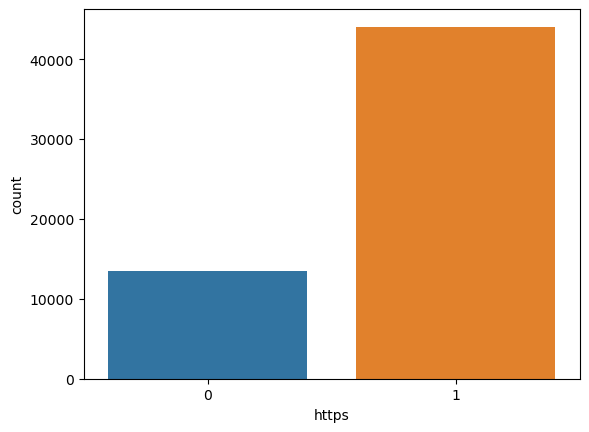

In [6]:
sns.countplot(x='https', data=df);

In [7]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['digits']= df['url'].apply(lambda i: digit_count(i))

In [8]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['letters']= df['url'].apply(lambda i: letter_count(i))

In [9]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
df['Shortining_Service'] = df['url'].apply(lambda x: Shortining_Service(x))

def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
df['having_ip_address'] = df['url'].apply(lambda i: having_ip_address(i))
df.head(20)
df['having_ip_address'].value_counts()

0    57129
1      403
Name: having_ip_address, dtype: int64

<AxesSubplot:>

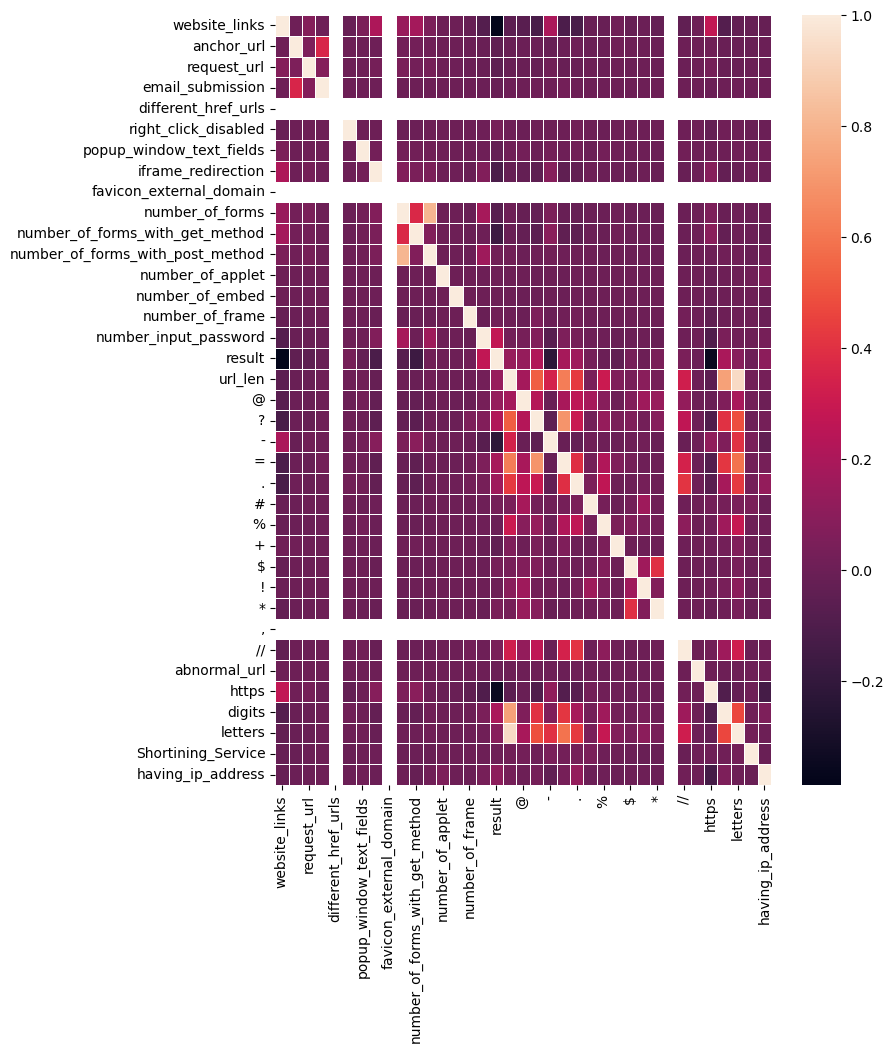

In [10]:
plt.figure(figsize=(8, 10))
sns.heatmap(df.corr(), linewidths=.5)

In [11]:
df.head(10)

,url,website_links,anchor_url,request_url,email_submission,different_href_urls,right_click_disabled,popup_window_text_fields,iframe_redirection,favicon_external_domain,...,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
0,http://intego3.info/EXEL/index.php,3,0,4,0,0,0,0,0,0,...,0,0,0,1,1,0,1,26,0,0
1,https://www.investopedia.com/terms/n/next-elev...,52,0,0,0,0,0,0,1,0,...,0,0,0,1,1,1,0,42,0,0
2,https://jobs.emss.org.uk/lcc.aspx,39,5,12,0,0,0,0,1,0,...,0,0,0,1,1,1,0,25,0,0
3,http://www.pracspedia.com/INS/one-time-passwor...,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,54,0,0
4,https://paribas-biznesplanet-logowanie.com,8,0,1,0,0,0,0,1,0,...,0,0,0,1,1,1,0,36,0,0
5,http://intego3.info/EXEL/index.php,3,0,4,0,0,0,0,0,0,...,0,0,0,1,1,0,1,26,0,0
6,https://www.investopedia.com/terms/n/next-elev...,52,0,0,0,0,0,0,1,0,...,0,0,0,1,1,1,0,42,0,0
7,https://jobs.emss.org.uk/lcc.aspx,39,5,12,0,0,0,0,1,0,...,0,0,0,1,1,1,0,25,0,0
8,http://www.pracspedia.com/INS/one-time-passwor...,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,54,0,0
9,https://paribas-biznesplanet-logowanie.com,8,0,1,0,0,0,0,1,0,...,0,0,0,1,1,1,0,36,0,0


In [12]:
Y1 = df['result']
X1 = df.drop(columns = ['url','domain'])

In [13]:
X1.head(2)

,website_links,anchor_url,request_url,email_submission,different_href_urls,right_click_disabled,popup_window_text_fields,iframe_redirection,favicon_external_domain,number_of_forms,...,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
0,3,0,4,0,0,0,0,0,0,1,...,0,0,0,1,1,0,1,26,0,0
1,52,0,0,0,0,0,0,1,0,1,...,0,0,0,1,1,1,0,42,0,0


In [14]:
Y1.head(2)

0    1
1    0
Name: result, dtype: int64

In [15]:
#data for learning without features 

X2 = df['url']
X2.head(2)

0                   http://intego3.info/EXEL/index.php
1    https://www.investopedia.com/terms/n/next-elev...
Name: url, dtype: object

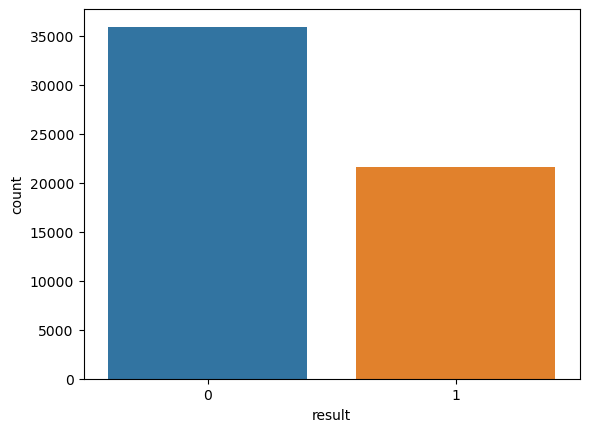

In [42]:
sns.countplot(x='result', data=df);

<AxesSubplot:>

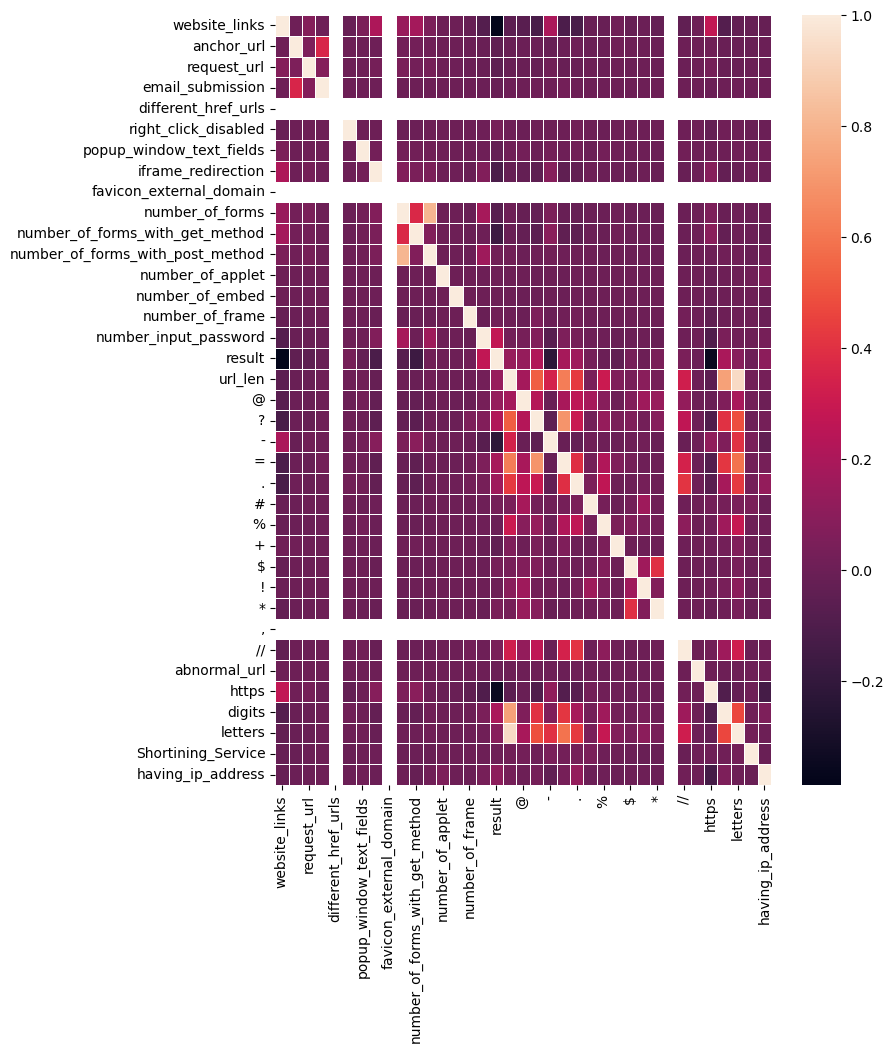

In [17]:
plt.figure(figsize=(8, 10))
sns.heatmap(df.corr(), linewidths=.5)

In [18]:
from sklearn.model_selection import train_test_split
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(X1,Y1,stratify = Y1,test_size = 0.2,random_state = 42)

In [19]:
X_train1 = np.expand_dims(X_train1, axis=-1)
X_test1 = np.expand_dims(X_test1, axis=-1)

X_train1.shape

(46025, 37, 1)

In [20]:
# CREATING DATASET WITHOUT PRIOR FEATURE EXTRACTION
ps = PorterStemmer()
corpus_train = []

def albumentations(X,corpus_t):
    for i in range(len(X)):
        print(i,"/",len(X))
        review = re.sub("[^a-zA-Z]"," ",X[i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in set(stopwords.words("english"))] #TO REMOVE STOP WORDS LIKE THE, A ETC 
        review = " ".join(review)
        corpus_t.append(review)
albumentations(X2,corpus_train)

0 / 57532
1 / 57532
2 / 57532
3 / 57532
4 / 57532
5 / 57532
6 / 57532
7 / 57532
8 / 57532
9 / 57532
10 / 57532
11 / 57532
12 / 57532
13 / 57532
14 / 57532
15 / 57532
16 / 57532
17 / 57532
18 / 57532
19 / 57532
20 / 57532
21 / 57532
22 / 57532
23 / 57532
24 / 57532
25 / 57532
26 / 57532
27 / 57532
28 / 57532
29 / 57532
30 / 57532
31 / 57532
32 / 57532
33 / 57532
34 / 57532
35 / 57532
36 / 57532
37 / 57532
38 / 57532
39 / 57532
40 / 57532
41 / 57532
42 / 57532
43 / 57532
44 / 57532
45 / 57532
46 / 57532
47 / 57532
48 / 57532
49 / 57532
50 / 57532
51 / 57532
52 / 57532
53 / 57532
54 / 57532
55 / 57532
56 / 57532
57 / 57532
58 / 57532
59 / 57532
60 / 57532
61 / 57532
62 / 57532
63 / 57532
64 / 57532
65 / 57532
66 / 57532
67 / 57532
68 / 57532
69 / 57532
70 / 57532
71 / 57532
72 / 57532
73 / 57532
74 / 57532
75 / 57532
76 / 57532
77 / 57532
78 / 57532
79 / 57532
80 / 57532
81 / 57532
82 / 57532
83 / 57532
84 / 57532
85 / 57532
86 / 57532
87 / 57532
88 / 57532
89 / 57532
90 / 57532
91 / 5753

694 / 57532
695 / 57532
696 / 57532
697 / 57532
698 / 57532
699 / 57532
700 / 57532
701 / 57532
702 / 57532
703 / 57532
704 / 57532
705 / 57532
706 / 57532
707 / 57532
708 / 57532
709 / 57532
710 / 57532
711 / 57532
712 / 57532
713 / 57532
714 / 57532
715 / 57532
716 / 57532
717 / 57532
718 / 57532
719 / 57532
720 / 57532
721 / 57532
722 / 57532
723 / 57532
724 / 57532
725 / 57532
726 / 57532
727 / 57532
728 / 57532
729 / 57532
730 / 57532
731 / 57532
732 / 57532
733 / 57532
734 / 57532
735 / 57532
736 / 57532
737 / 57532
738 / 57532
739 / 57532
740 / 57532
741 / 57532
742 / 57532
743 / 57532
744 / 57532
745 / 57532
746 / 57532
747 / 57532
748 / 57532
749 / 57532
750 / 57532
751 / 57532
752 / 57532
753 / 57532
754 / 57532
755 / 57532
756 / 57532
757 / 57532
758 / 57532
759 / 57532
760 / 57532
761 / 57532
762 / 57532
763 / 57532
764 / 57532
765 / 57532
766 / 57532
767 / 57532
768 / 57532
769 / 57532
770 / 57532
771 / 57532
772 / 57532
773 / 57532
774 / 57532
775 / 57532
776 / 57532
777 

1355 / 57532
1356 / 57532
1357 / 57532
1358 / 57532
1359 / 57532
1360 / 57532
1361 / 57532
1362 / 57532
1363 / 57532
1364 / 57532
1365 / 57532
1366 / 57532
1367 / 57532
1368 / 57532
1369 / 57532
1370 / 57532
1371 / 57532
1372 / 57532
1373 / 57532
1374 / 57532
1375 / 57532
1376 / 57532
1377 / 57532
1378 / 57532
1379 / 57532
1380 / 57532
1381 / 57532
1382 / 57532
1383 / 57532
1384 / 57532
1385 / 57532
1386 / 57532
1387 / 57532
1388 / 57532
1389 / 57532
1390 / 57532
1391 / 57532
1392 / 57532
1393 / 57532
1394 / 57532
1395 / 57532
1396 / 57532
1397 / 57532
1398 / 57532
1399 / 57532
1400 / 57532
1401 / 57532
1402 / 57532
1403 / 57532
1404 / 57532
1405 / 57532
1406 / 57532
1407 / 57532
1408 / 57532
1409 / 57532
1410 / 57532
1411 / 57532
1412 / 57532
1413 / 57532
1414 / 57532
1415 / 57532
1416 / 57532
1417 / 57532
1418 / 57532
1419 / 57532
1420 / 57532
1421 / 57532
1422 / 57532
1423 / 57532
1424 / 57532
1425 / 57532
1426 / 57532
1427 / 57532
1428 / 57532
1429 / 57532
1430 / 57532
1431 / 57532

2027 / 57532
2028 / 57532
2029 / 57532
2030 / 57532
2031 / 57532
2032 / 57532
2033 / 57532
2034 / 57532
2035 / 57532
2036 / 57532
2037 / 57532
2038 / 57532
2039 / 57532
2040 / 57532
2041 / 57532
2042 / 57532
2043 / 57532
2044 / 57532
2045 / 57532
2046 / 57532
2047 / 57532
2048 / 57532
2049 / 57532
2050 / 57532
2051 / 57532
2052 / 57532
2053 / 57532
2054 / 57532
2055 / 57532
2056 / 57532
2057 / 57532
2058 / 57532
2059 / 57532
2060 / 57532
2061 / 57532
2062 / 57532
2063 / 57532
2064 / 57532
2065 / 57532
2066 / 57532
2067 / 57532
2068 / 57532
2069 / 57532
2070 / 57532
2071 / 57532
2072 / 57532
2073 / 57532
2074 / 57532
2075 / 57532
2076 / 57532
2077 / 57532
2078 / 57532
2079 / 57532
2080 / 57532
2081 / 57532
2082 / 57532
2083 / 57532
2084 / 57532
2085 / 57532
2086 / 57532
2087 / 57532
2088 / 57532
2089 / 57532
2090 / 57532
2091 / 57532
2092 / 57532
2093 / 57532
2094 / 57532
2095 / 57532
2096 / 57532
2097 / 57532
2098 / 57532
2099 / 57532
2100 / 57532
2101 / 57532
2102 / 57532
2103 / 57532

2695 / 57532
2696 / 57532
2697 / 57532
2698 / 57532
2699 / 57532
2700 / 57532
2701 / 57532
2702 / 57532
2703 / 57532
2704 / 57532
2705 / 57532
2706 / 57532
2707 / 57532
2708 / 57532
2709 / 57532
2710 / 57532
2711 / 57532
2712 / 57532
2713 / 57532
2714 / 57532
2715 / 57532
2716 / 57532
2717 / 57532
2718 / 57532
2719 / 57532
2720 / 57532
2721 / 57532
2722 / 57532
2723 / 57532
2724 / 57532
2725 / 57532
2726 / 57532
2727 / 57532
2728 / 57532
2729 / 57532
2730 / 57532
2731 / 57532
2732 / 57532
2733 / 57532
2734 / 57532
2735 / 57532
2736 / 57532
2737 / 57532
2738 / 57532
2739 / 57532
2740 / 57532
2741 / 57532
2742 / 57532
2743 / 57532
2744 / 57532
2745 / 57532
2746 / 57532
2747 / 57532
2748 / 57532
2749 / 57532
2750 / 57532
2751 / 57532
2752 / 57532
2753 / 57532
2754 / 57532
2755 / 57532
2756 / 57532
2757 / 57532
2758 / 57532
2759 / 57532
2760 / 57532
2761 / 57532
2762 / 57532
2763 / 57532
2764 / 57532
2765 / 57532
2766 / 57532
2767 / 57532
2768 / 57532
2769 / 57532
2770 / 57532
2771 / 57532

3346 / 57532
3347 / 57532
3348 / 57532
3349 / 57532
3350 / 57532
3351 / 57532
3352 / 57532
3353 / 57532
3354 / 57532
3355 / 57532
3356 / 57532
3357 / 57532
3358 / 57532
3359 / 57532
3360 / 57532
3361 / 57532
3362 / 57532
3363 / 57532
3364 / 57532
3365 / 57532
3366 / 57532
3367 / 57532
3368 / 57532
3369 / 57532
3370 / 57532
3371 / 57532
3372 / 57532
3373 / 57532
3374 / 57532
3375 / 57532
3376 / 57532
3377 / 57532
3378 / 57532
3379 / 57532
3380 / 57532
3381 / 57532
3382 / 57532
3383 / 57532
3384 / 57532
3385 / 57532
3386 / 57532
3387 / 57532
3388 / 57532
3389 / 57532
3390 / 57532
3391 / 57532
3392 / 57532
3393 / 57532
3394 / 57532
3395 / 57532
3396 / 57532
3397 / 57532
3398 / 57532
3399 / 57532
3400 / 57532
3401 / 57532
3402 / 57532
3403 / 57532
3404 / 57532
3405 / 57532
3406 / 57532
3407 / 57532
3408 / 57532
3409 / 57532
3410 / 57532
3411 / 57532
3412 / 57532
3413 / 57532
3414 / 57532
3415 / 57532
3416 / 57532
3417 / 57532
3418 / 57532
3419 / 57532
3420 / 57532
3421 / 57532
3422 / 57532

4018 / 57532
4019 / 57532
4020 / 57532
4021 / 57532
4022 / 57532
4023 / 57532
4024 / 57532
4025 / 57532
4026 / 57532
4027 / 57532
4028 / 57532
4029 / 57532
4030 / 57532
4031 / 57532
4032 / 57532
4033 / 57532
4034 / 57532
4035 / 57532
4036 / 57532
4037 / 57532
4038 / 57532
4039 / 57532
4040 / 57532
4041 / 57532
4042 / 57532
4043 / 57532
4044 / 57532
4045 / 57532
4046 / 57532
4047 / 57532
4048 / 57532
4049 / 57532
4050 / 57532
4051 / 57532
4052 / 57532
4053 / 57532
4054 / 57532
4055 / 57532
4056 / 57532
4057 / 57532
4058 / 57532
4059 / 57532
4060 / 57532
4061 / 57532
4062 / 57532
4063 / 57532
4064 / 57532
4065 / 57532
4066 / 57532
4067 / 57532
4068 / 57532
4069 / 57532
4070 / 57532
4071 / 57532
4072 / 57532
4073 / 57532
4074 / 57532
4075 / 57532
4076 / 57532
4077 / 57532
4078 / 57532
4079 / 57532
4080 / 57532
4081 / 57532
4082 / 57532
4083 / 57532
4084 / 57532
4085 / 57532
4086 / 57532
4087 / 57532
4088 / 57532
4089 / 57532
4090 / 57532
4091 / 57532
4092 / 57532
4093 / 57532
4094 / 57532

4694 / 57532
4695 / 57532
4696 / 57532
4697 / 57532
4698 / 57532
4699 / 57532
4700 / 57532
4701 / 57532
4702 / 57532
4703 / 57532
4704 / 57532
4705 / 57532
4706 / 57532
4707 / 57532
4708 / 57532
4709 / 57532
4710 / 57532
4711 / 57532
4712 / 57532
4713 / 57532
4714 / 57532
4715 / 57532
4716 / 57532
4717 / 57532
4718 / 57532
4719 / 57532
4720 / 57532
4721 / 57532
4722 / 57532
4723 / 57532
4724 / 57532
4725 / 57532
4726 / 57532
4727 / 57532
4728 / 57532
4729 / 57532
4730 / 57532
4731 / 57532
4732 / 57532
4733 / 57532
4734 / 57532
4735 / 57532
4736 / 57532
4737 / 57532
4738 / 57532
4739 / 57532
4740 / 57532
4741 / 57532
4742 / 57532
4743 / 57532
4744 / 57532
4745 / 57532
4746 / 57532
4747 / 57532
4748 / 57532
4749 / 57532
4750 / 57532
4751 / 57532
4752 / 57532
4753 / 57532
4754 / 57532
4755 / 57532
4756 / 57532
4757 / 57532
4758 / 57532
4759 / 57532
4760 / 57532
4761 / 57532
4762 / 57532
4763 / 57532
4764 / 57532
4765 / 57532
4766 / 57532
4767 / 57532
4768 / 57532
4769 / 57532
4770 / 57532

5336 / 57532
5337 / 57532
5338 / 57532
5339 / 57532
5340 / 57532
5341 / 57532
5342 / 57532
5343 / 57532
5344 / 57532
5345 / 57532
5346 / 57532
5347 / 57532
5348 / 57532
5349 / 57532
5350 / 57532
5351 / 57532
5352 / 57532
5353 / 57532
5354 / 57532
5355 / 57532
5356 / 57532
5357 / 57532
5358 / 57532
5359 / 57532
5360 / 57532
5361 / 57532
5362 / 57532
5363 / 57532
5364 / 57532
5365 / 57532
5366 / 57532
5367 / 57532
5368 / 57532
5369 / 57532
5370 / 57532
5371 / 57532
5372 / 57532
5373 / 57532
5374 / 57532
5375 / 57532
5376 / 57532
5377 / 57532
5378 / 57532
5379 / 57532
5380 / 57532
5381 / 57532
5382 / 57532
5383 / 57532
5384 / 57532
5385 / 57532
5386 / 57532
5387 / 57532
5388 / 57532
5389 / 57532
5390 / 57532
5391 / 57532
5392 / 57532
5393 / 57532
5394 / 57532
5395 / 57532
5396 / 57532
5397 / 57532
5398 / 57532
5399 / 57532
5400 / 57532
5401 / 57532
5402 / 57532
5403 / 57532
5404 / 57532
5405 / 57532
5406 / 57532
5407 / 57532
5408 / 57532
5409 / 57532
5410 / 57532
5411 / 57532
5412 / 57532

6009 / 57532
6010 / 57532
6011 / 57532
6012 / 57532
6013 / 57532
6014 / 57532
6015 / 57532
6016 / 57532
6017 / 57532
6018 / 57532
6019 / 57532
6020 / 57532
6021 / 57532
6022 / 57532
6023 / 57532
6024 / 57532
6025 / 57532
6026 / 57532
6027 / 57532
6028 / 57532
6029 / 57532
6030 / 57532
6031 / 57532
6032 / 57532
6033 / 57532
6034 / 57532
6035 / 57532
6036 / 57532
6037 / 57532
6038 / 57532
6039 / 57532
6040 / 57532
6041 / 57532
6042 / 57532
6043 / 57532
6044 / 57532
6045 / 57532
6046 / 57532
6047 / 57532
6048 / 57532
6049 / 57532
6050 / 57532
6051 / 57532
6052 / 57532
6053 / 57532
6054 / 57532
6055 / 57532
6056 / 57532
6057 / 57532
6058 / 57532
6059 / 57532
6060 / 57532
6061 / 57532
6062 / 57532
6063 / 57532
6064 / 57532
6065 / 57532
6066 / 57532
6067 / 57532
6068 / 57532
6069 / 57532
6070 / 57532
6071 / 57532
6072 / 57532
6073 / 57532
6074 / 57532
6075 / 57532
6076 / 57532
6077 / 57532
6078 / 57532
6079 / 57532
6080 / 57532
6081 / 57532
6082 / 57532
6083 / 57532
6084 / 57532
6085 / 57532

6674 / 57532
6675 / 57532
6676 / 57532
6677 / 57532
6678 / 57532
6679 / 57532
6680 / 57532
6681 / 57532
6682 / 57532
6683 / 57532
6684 / 57532
6685 / 57532
6686 / 57532
6687 / 57532
6688 / 57532
6689 / 57532
6690 / 57532
6691 / 57532
6692 / 57532
6693 / 57532
6694 / 57532
6695 / 57532
6696 / 57532
6697 / 57532
6698 / 57532
6699 / 57532
6700 / 57532
6701 / 57532
6702 / 57532
6703 / 57532
6704 / 57532
6705 / 57532
6706 / 57532
6707 / 57532
6708 / 57532
6709 / 57532
6710 / 57532
6711 / 57532
6712 / 57532
6713 / 57532
6714 / 57532
6715 / 57532
6716 / 57532
6717 / 57532
6718 / 57532
6719 / 57532
6720 / 57532
6721 / 57532
6722 / 57532
6723 / 57532
6724 / 57532
6725 / 57532
6726 / 57532
6727 / 57532
6728 / 57532
6729 / 57532
6730 / 57532
6731 / 57532
6732 / 57532
6733 / 57532
6734 / 57532
6735 / 57532
6736 / 57532
6737 / 57532
6738 / 57532
6739 / 57532
6740 / 57532
6741 / 57532
6742 / 57532
6743 / 57532
6744 / 57532
6745 / 57532
6746 / 57532
6747 / 57532
6748 / 57532
6749 / 57532
6750 / 57532

7316 / 57532
7317 / 57532
7318 / 57532
7319 / 57532
7320 / 57532
7321 / 57532
7322 / 57532
7323 / 57532
7324 / 57532
7325 / 57532
7326 / 57532
7327 / 57532
7328 / 57532
7329 / 57532
7330 / 57532
7331 / 57532
7332 / 57532
7333 / 57532
7334 / 57532
7335 / 57532
7336 / 57532
7337 / 57532
7338 / 57532
7339 / 57532
7340 / 57532
7341 / 57532
7342 / 57532
7343 / 57532
7344 / 57532
7345 / 57532
7346 / 57532
7347 / 57532
7348 / 57532
7349 / 57532
7350 / 57532
7351 / 57532
7352 / 57532
7353 / 57532
7354 / 57532
7355 / 57532
7356 / 57532
7357 / 57532
7358 / 57532
7359 / 57532
7360 / 57532
7361 / 57532
7362 / 57532
7363 / 57532
7364 / 57532
7365 / 57532
7366 / 57532
7367 / 57532
7368 / 57532
7369 / 57532
7370 / 57532
7371 / 57532
7372 / 57532
7373 / 57532
7374 / 57532
7375 / 57532
7376 / 57532
7377 / 57532
7378 / 57532
7379 / 57532
7380 / 57532
7381 / 57532
7382 / 57532
7383 / 57532
7384 / 57532
7385 / 57532
7386 / 57532
7387 / 57532
7388 / 57532
7389 / 57532
7390 / 57532
7391 / 57532
7392 / 57532

7963 / 57532
7964 / 57532
7965 / 57532
7966 / 57532
7967 / 57532
7968 / 57532
7969 / 57532
7970 / 57532
7971 / 57532
7972 / 57532
7973 / 57532
7974 / 57532
7975 / 57532
7976 / 57532
7977 / 57532
7978 / 57532
7979 / 57532
7980 / 57532
7981 / 57532
7982 / 57532
7983 / 57532
7984 / 57532
7985 / 57532
7986 / 57532
7987 / 57532
7988 / 57532
7989 / 57532
7990 / 57532
7991 / 57532
7992 / 57532
7993 / 57532
7994 / 57532
7995 / 57532
7996 / 57532
7997 / 57532
7998 / 57532
7999 / 57532
8000 / 57532
8001 / 57532
8002 / 57532
8003 / 57532
8004 / 57532
8005 / 57532
8006 / 57532
8007 / 57532
8008 / 57532
8009 / 57532
8010 / 57532
8011 / 57532
8012 / 57532
8013 / 57532
8014 / 57532
8015 / 57532
8016 / 57532
8017 / 57532
8018 / 57532
8019 / 57532
8020 / 57532
8021 / 57532
8022 / 57532
8023 / 57532
8024 / 57532
8025 / 57532
8026 / 57532
8027 / 57532
8028 / 57532
8029 / 57532
8030 / 57532
8031 / 57532
8032 / 57532
8033 / 57532
8034 / 57532
8035 / 57532
8036 / 57532
8037 / 57532
8038 / 57532
8039 / 57532

8619 / 57532
8620 / 57532
8621 / 57532
8622 / 57532
8623 / 57532
8624 / 57532
8625 / 57532
8626 / 57532
8627 / 57532
8628 / 57532
8629 / 57532
8630 / 57532
8631 / 57532
8632 / 57532
8633 / 57532
8634 / 57532
8635 / 57532
8636 / 57532
8637 / 57532
8638 / 57532
8639 / 57532
8640 / 57532
8641 / 57532
8642 / 57532
8643 / 57532
8644 / 57532
8645 / 57532
8646 / 57532
8647 / 57532
8648 / 57532
8649 / 57532
8650 / 57532
8651 / 57532
8652 / 57532
8653 / 57532
8654 / 57532
8655 / 57532
8656 / 57532
8657 / 57532
8658 / 57532
8659 / 57532
8660 / 57532
8661 / 57532
8662 / 57532
8663 / 57532
8664 / 57532
8665 / 57532
8666 / 57532
8667 / 57532
8668 / 57532
8669 / 57532
8670 / 57532
8671 / 57532
8672 / 57532
8673 / 57532
8674 / 57532
8675 / 57532
8676 / 57532
8677 / 57532
8678 / 57532
8679 / 57532
8680 / 57532
8681 / 57532
8682 / 57532
8683 / 57532
8684 / 57532
8685 / 57532
8686 / 57532
8687 / 57532
8688 / 57532
8689 / 57532
8690 / 57532
8691 / 57532
8692 / 57532
8693 / 57532
8694 / 57532
8695 / 57532

9286 / 57532
9287 / 57532
9288 / 57532
9289 / 57532
9290 / 57532
9291 / 57532
9292 / 57532
9293 / 57532
9294 / 57532
9295 / 57532
9296 / 57532
9297 / 57532
9298 / 57532
9299 / 57532
9300 / 57532
9301 / 57532
9302 / 57532
9303 / 57532
9304 / 57532
9305 / 57532
9306 / 57532
9307 / 57532
9308 / 57532
9309 / 57532
9310 / 57532
9311 / 57532
9312 / 57532
9313 / 57532
9314 / 57532
9315 / 57532
9316 / 57532
9317 / 57532
9318 / 57532
9319 / 57532
9320 / 57532
9321 / 57532
9322 / 57532
9323 / 57532
9324 / 57532
9325 / 57532
9326 / 57532
9327 / 57532
9328 / 57532
9329 / 57532
9330 / 57532
9331 / 57532
9332 / 57532
9333 / 57532
9334 / 57532
9335 / 57532
9336 / 57532
9337 / 57532
9338 / 57532
9339 / 57532
9340 / 57532
9341 / 57532
9342 / 57532
9343 / 57532
9344 / 57532
9345 / 57532
9346 / 57532
9347 / 57532
9348 / 57532
9349 / 57532
9350 / 57532
9351 / 57532
9352 / 57532
9353 / 57532
9354 / 57532
9355 / 57532
9356 / 57532
9357 / 57532
9358 / 57532
9359 / 57532
9360 / 57532
9361 / 57532
9362 / 57532

9917 / 57532
9918 / 57532
9919 / 57532
9920 / 57532
9921 / 57532
9922 / 57532
9923 / 57532
9924 / 57532
9925 / 57532
9926 / 57532
9927 / 57532
9928 / 57532
9929 / 57532
9930 / 57532
9931 / 57532
9932 / 57532
9933 / 57532
9934 / 57532
9935 / 57532
9936 / 57532
9937 / 57532
9938 / 57532
9939 / 57532
9940 / 57532
9941 / 57532
9942 / 57532
9943 / 57532
9944 / 57532
9945 / 57532
9946 / 57532
9947 / 57532
9948 / 57532
9949 / 57532
9950 / 57532
9951 / 57532
9952 / 57532
9953 / 57532
9954 / 57532
9955 / 57532
9956 / 57532
9957 / 57532
9958 / 57532
9959 / 57532
9960 / 57532
9961 / 57532
9962 / 57532
9963 / 57532
9964 / 57532
9965 / 57532
9966 / 57532
9967 / 57532
9968 / 57532
9969 / 57532
9970 / 57532
9971 / 57532
9972 / 57532
9973 / 57532
9974 / 57532
9975 / 57532
9976 / 57532
9977 / 57532
9978 / 57532
9979 / 57532
9980 / 57532
9981 / 57532
9982 / 57532
9983 / 57532
9984 / 57532
9985 / 57532
9986 / 57532
9987 / 57532
9988 / 57532
9989 / 57532
9990 / 57532
9991 / 57532
9992 / 57532
9993 / 57532

10525 / 57532
10526 / 57532
10527 / 57532
10528 / 57532
10529 / 57532
10530 / 57532
10531 / 57532
10532 / 57532
10533 / 57532
10534 / 57532
10535 / 57532
10536 / 57532
10537 / 57532
10538 / 57532
10539 / 57532
10540 / 57532
10541 / 57532
10542 / 57532
10543 / 57532
10544 / 57532
10545 / 57532
10546 / 57532
10547 / 57532
10548 / 57532
10549 / 57532
10550 / 57532
10551 / 57532
10552 / 57532
10553 / 57532
10554 / 57532
10555 / 57532
10556 / 57532
10557 / 57532
10558 / 57532
10559 / 57532
10560 / 57532
10561 / 57532
10562 / 57532
10563 / 57532
10564 / 57532
10565 / 57532
10566 / 57532
10567 / 57532
10568 / 57532
10569 / 57532
10570 / 57532
10571 / 57532
10572 / 57532
10573 / 57532
10574 / 57532
10575 / 57532
10576 / 57532
10577 / 57532
10578 / 57532
10579 / 57532
10580 / 57532
10581 / 57532
10582 / 57532
10583 / 57532
10584 / 57532
10585 / 57532
10586 / 57532
10587 / 57532
10588 / 57532
10589 / 57532
10590 / 57532
10591 / 57532
10592 / 57532
10593 / 57532
10594 / 57532
10595 / 57532
10596 

11139 / 57532
11140 / 57532
11141 / 57532
11142 / 57532
11143 / 57532
11144 / 57532
11145 / 57532
11146 / 57532
11147 / 57532
11148 / 57532
11149 / 57532
11150 / 57532
11151 / 57532
11152 / 57532
11153 / 57532
11154 / 57532
11155 / 57532
11156 / 57532
11157 / 57532
11158 / 57532
11159 / 57532
11160 / 57532
11161 / 57532
11162 / 57532
11163 / 57532
11164 / 57532
11165 / 57532
11166 / 57532
11167 / 57532
11168 / 57532
11169 / 57532
11170 / 57532
11171 / 57532
11172 / 57532
11173 / 57532
11174 / 57532
11175 / 57532
11176 / 57532
11177 / 57532
11178 / 57532
11179 / 57532
11180 / 57532
11181 / 57532
11182 / 57532
11183 / 57532
11184 / 57532
11185 / 57532
11186 / 57532
11187 / 57532
11188 / 57532
11189 / 57532
11190 / 57532
11191 / 57532
11192 / 57532
11193 / 57532
11194 / 57532
11195 / 57532
11196 / 57532
11197 / 57532
11198 / 57532
11199 / 57532
11200 / 57532
11201 / 57532
11202 / 57532
11203 / 57532
11204 / 57532
11205 / 57532
11206 / 57532
11207 / 57532
11208 / 57532
11209 / 57532
11210 

11728 / 57532
11729 / 57532
11730 / 57532
11731 / 57532
11732 / 57532
11733 / 57532
11734 / 57532
11735 / 57532
11736 / 57532
11737 / 57532
11738 / 57532
11739 / 57532
11740 / 57532
11741 / 57532
11742 / 57532
11743 / 57532
11744 / 57532
11745 / 57532
11746 / 57532
11747 / 57532
11748 / 57532
11749 / 57532
11750 / 57532
11751 / 57532
11752 / 57532
11753 / 57532
11754 / 57532
11755 / 57532
11756 / 57532
11757 / 57532
11758 / 57532
11759 / 57532
11760 / 57532
11761 / 57532
11762 / 57532
11763 / 57532
11764 / 57532
11765 / 57532
11766 / 57532
11767 / 57532
11768 / 57532
11769 / 57532
11770 / 57532
11771 / 57532
11772 / 57532
11773 / 57532
11774 / 57532
11775 / 57532
11776 / 57532
11777 / 57532
11778 / 57532
11779 / 57532
11780 / 57532
11781 / 57532
11782 / 57532
11783 / 57532
11784 / 57532
11785 / 57532
11786 / 57532
11787 / 57532
11788 / 57532
11789 / 57532
11790 / 57532
11791 / 57532
11792 / 57532
11793 / 57532
11794 / 57532
11795 / 57532
11796 / 57532
11797 / 57532
11798 / 57532
11799 

12321 / 57532
12322 / 57532
12323 / 57532
12324 / 57532
12325 / 57532
12326 / 57532
12327 / 57532
12328 / 57532
12329 / 57532
12330 / 57532
12331 / 57532
12332 / 57532
12333 / 57532
12334 / 57532
12335 / 57532
12336 / 57532
12337 / 57532
12338 / 57532
12339 / 57532
12340 / 57532
12341 / 57532
12342 / 57532
12343 / 57532
12344 / 57532
12345 / 57532
12346 / 57532
12347 / 57532
12348 / 57532
12349 / 57532
12350 / 57532
12351 / 57532
12352 / 57532
12353 / 57532
12354 / 57532
12355 / 57532
12356 / 57532
12357 / 57532
12358 / 57532
12359 / 57532
12360 / 57532
12361 / 57532
12362 / 57532
12363 / 57532
12364 / 57532
12365 / 57532
12366 / 57532
12367 / 57532
12368 / 57532
12369 / 57532
12370 / 57532
12371 / 57532
12372 / 57532
12373 / 57532
12374 / 57532
12375 / 57532
12376 / 57532
12377 / 57532
12378 / 57532
12379 / 57532
12380 / 57532
12381 / 57532
12382 / 57532
12383 / 57532
12384 / 57532
12385 / 57532
12386 / 57532
12387 / 57532
12388 / 57532
12389 / 57532
12390 / 57532
12391 / 57532
12392 

12941 / 57532
12942 / 57532
12943 / 57532
12944 / 57532
12945 / 57532
12946 / 57532
12947 / 57532
12948 / 57532
12949 / 57532
12950 / 57532
12951 / 57532
12952 / 57532
12953 / 57532
12954 / 57532
12955 / 57532
12956 / 57532
12957 / 57532
12958 / 57532
12959 / 57532
12960 / 57532
12961 / 57532
12962 / 57532
12963 / 57532
12964 / 57532
12965 / 57532
12966 / 57532
12967 / 57532
12968 / 57532
12969 / 57532
12970 / 57532
12971 / 57532
12972 / 57532
12973 / 57532
12974 / 57532
12975 / 57532
12976 / 57532
12977 / 57532
12978 / 57532
12979 / 57532
12980 / 57532
12981 / 57532
12982 / 57532
12983 / 57532
12984 / 57532
12985 / 57532
12986 / 57532
12987 / 57532
12988 / 57532
12989 / 57532
12990 / 57532
12991 / 57532
12992 / 57532
12993 / 57532
12994 / 57532
12995 / 57532
12996 / 57532
12997 / 57532
12998 / 57532
12999 / 57532
13000 / 57532
13001 / 57532
13002 / 57532
13003 / 57532
13004 / 57532
13005 / 57532
13006 / 57532
13007 / 57532
13008 / 57532
13009 / 57532
13010 / 57532
13011 / 57532
13012 

13528 / 57532
13529 / 57532
13530 / 57532
13531 / 57532
13532 / 57532
13533 / 57532
13534 / 57532
13535 / 57532
13536 / 57532
13537 / 57532
13538 / 57532
13539 / 57532
13540 / 57532
13541 / 57532
13542 / 57532
13543 / 57532
13544 / 57532
13545 / 57532
13546 / 57532
13547 / 57532
13548 / 57532
13549 / 57532
13550 / 57532
13551 / 57532
13552 / 57532
13553 / 57532
13554 / 57532
13555 / 57532
13556 / 57532
13557 / 57532
13558 / 57532
13559 / 57532
13560 / 57532
13561 / 57532
13562 / 57532
13563 / 57532
13564 / 57532
13565 / 57532
13566 / 57532
13567 / 57532
13568 / 57532
13569 / 57532
13570 / 57532
13571 / 57532
13572 / 57532
13573 / 57532
13574 / 57532
13575 / 57532
13576 / 57532
13577 / 57532
13578 / 57532
13579 / 57532
13580 / 57532
13581 / 57532
13582 / 57532
13583 / 57532
13584 / 57532
13585 / 57532
13586 / 57532
13587 / 57532
13588 / 57532
13589 / 57532
13590 / 57532
13591 / 57532
13592 / 57532
13593 / 57532
13594 / 57532
13595 / 57532
13596 / 57532
13597 / 57532
13598 / 57532
13599 

14152 / 57532
14153 / 57532
14154 / 57532
14155 / 57532
14156 / 57532
14157 / 57532
14158 / 57532
14159 / 57532
14160 / 57532
14161 / 57532
14162 / 57532
14163 / 57532
14164 / 57532
14165 / 57532
14166 / 57532
14167 / 57532
14168 / 57532
14169 / 57532
14170 / 57532
14171 / 57532
14172 / 57532
14173 / 57532
14174 / 57532
14175 / 57532
14176 / 57532
14177 / 57532
14178 / 57532
14179 / 57532
14180 / 57532
14181 / 57532
14182 / 57532
14183 / 57532
14184 / 57532
14185 / 57532
14186 / 57532
14187 / 57532
14188 / 57532
14189 / 57532
14190 / 57532
14191 / 57532
14192 / 57532
14193 / 57532
14194 / 57532
14195 / 57532
14196 / 57532
14197 / 57532
14198 / 57532
14199 / 57532
14200 / 57532
14201 / 57532
14202 / 57532
14203 / 57532
14204 / 57532
14205 / 57532
14206 / 57532
14207 / 57532
14208 / 57532
14209 / 57532
14210 / 57532
14211 / 57532
14212 / 57532
14213 / 57532
14214 / 57532
14215 / 57532
14216 / 57532
14217 / 57532
14218 / 57532
14219 / 57532
14220 / 57532
14221 / 57532
14222 / 57532
14223 

14791 / 57532
14792 / 57532
14793 / 57532
14794 / 57532
14795 / 57532
14796 / 57532
14797 / 57532
14798 / 57532
14799 / 57532
14800 / 57532
14801 / 57532
14802 / 57532
14803 / 57532
14804 / 57532
14805 / 57532
14806 / 57532
14807 / 57532
14808 / 57532
14809 / 57532
14810 / 57532
14811 / 57532
14812 / 57532
14813 / 57532
14814 / 57532
14815 / 57532
14816 / 57532
14817 / 57532
14818 / 57532
14819 / 57532
14820 / 57532
14821 / 57532
14822 / 57532
14823 / 57532
14824 / 57532
14825 / 57532
14826 / 57532
14827 / 57532
14828 / 57532
14829 / 57532
14830 / 57532
14831 / 57532
14832 / 57532
14833 / 57532
14834 / 57532
14835 / 57532
14836 / 57532
14837 / 57532
14838 / 57532
14839 / 57532
14840 / 57532
14841 / 57532
14842 / 57532
14843 / 57532
14844 / 57532
14845 / 57532
14846 / 57532
14847 / 57532
14848 / 57532
14849 / 57532
14850 / 57532
14851 / 57532
14852 / 57532
14853 / 57532
14854 / 57532
14855 / 57532
14856 / 57532
14857 / 57532
14858 / 57532
14859 / 57532
14860 / 57532
14861 / 57532
14862 

15402 / 57532
15403 / 57532
15404 / 57532
15405 / 57532
15406 / 57532
15407 / 57532
15408 / 57532
15409 / 57532
15410 / 57532
15411 / 57532
15412 / 57532
15413 / 57532
15414 / 57532
15415 / 57532
15416 / 57532
15417 / 57532
15418 / 57532
15419 / 57532
15420 / 57532
15421 / 57532
15422 / 57532
15423 / 57532
15424 / 57532
15425 / 57532
15426 / 57532
15427 / 57532
15428 / 57532
15429 / 57532
15430 / 57532
15431 / 57532
15432 / 57532
15433 / 57532
15434 / 57532
15435 / 57532
15436 / 57532
15437 / 57532
15438 / 57532
15439 / 57532
15440 / 57532
15441 / 57532
15442 / 57532
15443 / 57532
15444 / 57532
15445 / 57532
15446 / 57532
15447 / 57532
15448 / 57532
15449 / 57532
15450 / 57532
15451 / 57532
15452 / 57532
15453 / 57532
15454 / 57532
15455 / 57532
15456 / 57532
15457 / 57532
15458 / 57532
15459 / 57532
15460 / 57532
15461 / 57532
15462 / 57532
15463 / 57532
15464 / 57532
15465 / 57532
15466 / 57532
15467 / 57532
15468 / 57532
15469 / 57532
15470 / 57532
15471 / 57532
15472 / 57532
15473 

16031 / 57532
16032 / 57532
16033 / 57532
16034 / 57532
16035 / 57532
16036 / 57532
16037 / 57532
16038 / 57532
16039 / 57532
16040 / 57532
16041 / 57532
16042 / 57532
16043 / 57532
16044 / 57532
16045 / 57532
16046 / 57532
16047 / 57532
16048 / 57532
16049 / 57532
16050 / 57532
16051 / 57532
16052 / 57532
16053 / 57532
16054 / 57532
16055 / 57532
16056 / 57532
16057 / 57532
16058 / 57532
16059 / 57532
16060 / 57532
16061 / 57532
16062 / 57532
16063 / 57532
16064 / 57532
16065 / 57532
16066 / 57532
16067 / 57532
16068 / 57532
16069 / 57532
16070 / 57532
16071 / 57532
16072 / 57532
16073 / 57532
16074 / 57532
16075 / 57532
16076 / 57532
16077 / 57532
16078 / 57532
16079 / 57532
16080 / 57532
16081 / 57532
16082 / 57532
16083 / 57532
16084 / 57532
16085 / 57532
16086 / 57532
16087 / 57532
16088 / 57532
16089 / 57532
16090 / 57532
16091 / 57532
16092 / 57532
16093 / 57532
16094 / 57532
16095 / 57532
16096 / 57532
16097 / 57532
16098 / 57532
16099 / 57532
16100 / 57532
16101 / 57532
16102 

16621 / 57532
16622 / 57532
16623 / 57532
16624 / 57532
16625 / 57532
16626 / 57532
16627 / 57532
16628 / 57532
16629 / 57532
16630 / 57532
16631 / 57532
16632 / 57532
16633 / 57532
16634 / 57532
16635 / 57532
16636 / 57532
16637 / 57532
16638 / 57532
16639 / 57532
16640 / 57532
16641 / 57532
16642 / 57532
16643 / 57532
16644 / 57532
16645 / 57532
16646 / 57532
16647 / 57532
16648 / 57532
16649 / 57532
16650 / 57532
16651 / 57532
16652 / 57532
16653 / 57532
16654 / 57532
16655 / 57532
16656 / 57532
16657 / 57532
16658 / 57532
16659 / 57532
16660 / 57532
16661 / 57532
16662 / 57532
16663 / 57532
16664 / 57532
16665 / 57532
16666 / 57532
16667 / 57532
16668 / 57532
16669 / 57532
16670 / 57532
16671 / 57532
16672 / 57532
16673 / 57532
16674 / 57532
16675 / 57532
16676 / 57532
16677 / 57532
16678 / 57532
16679 / 57532
16680 / 57532
16681 / 57532
16682 / 57532
16683 / 57532
16684 / 57532
16685 / 57532
16686 / 57532
16687 / 57532
16688 / 57532
16689 / 57532
16690 / 57532
16691 / 57532
16692 

17218 / 57532
17219 / 57532
17220 / 57532
17221 / 57532
17222 / 57532
17223 / 57532
17224 / 57532
17225 / 57532
17226 / 57532
17227 / 57532
17228 / 57532
17229 / 57532
17230 / 57532
17231 / 57532
17232 / 57532
17233 / 57532
17234 / 57532
17235 / 57532
17236 / 57532
17237 / 57532
17238 / 57532
17239 / 57532
17240 / 57532
17241 / 57532
17242 / 57532
17243 / 57532
17244 / 57532
17245 / 57532
17246 / 57532
17247 / 57532
17248 / 57532
17249 / 57532
17250 / 57532
17251 / 57532
17252 / 57532
17253 / 57532
17254 / 57532
17255 / 57532
17256 / 57532
17257 / 57532
17258 / 57532
17259 / 57532
17260 / 57532
17261 / 57532
17262 / 57532
17263 / 57532
17264 / 57532
17265 / 57532
17266 / 57532
17267 / 57532
17268 / 57532
17269 / 57532
17270 / 57532
17271 / 57532
17272 / 57532
17273 / 57532
17274 / 57532
17275 / 57532
17276 / 57532
17277 / 57532
17278 / 57532
17279 / 57532
17280 / 57532
17281 / 57532
17282 / 57532
17283 / 57532
17284 / 57532
17285 / 57532
17286 / 57532
17287 / 57532
17288 / 57532
17289 

17827 / 57532
17828 / 57532
17829 / 57532
17830 / 57532
17831 / 57532
17832 / 57532
17833 / 57532
17834 / 57532
17835 / 57532
17836 / 57532
17837 / 57532
17838 / 57532
17839 / 57532
17840 / 57532
17841 / 57532
17842 / 57532
17843 / 57532
17844 / 57532
17845 / 57532
17846 / 57532
17847 / 57532
17848 / 57532
17849 / 57532
17850 / 57532
17851 / 57532
17852 / 57532
17853 / 57532
17854 / 57532
17855 / 57532
17856 / 57532
17857 / 57532
17858 / 57532
17859 / 57532
17860 / 57532
17861 / 57532
17862 / 57532
17863 / 57532
17864 / 57532
17865 / 57532
17866 / 57532
17867 / 57532
17868 / 57532
17869 / 57532
17870 / 57532
17871 / 57532
17872 / 57532
17873 / 57532
17874 / 57532
17875 / 57532
17876 / 57532
17877 / 57532
17878 / 57532
17879 / 57532
17880 / 57532
17881 / 57532
17882 / 57532
17883 / 57532
17884 / 57532
17885 / 57532
17886 / 57532
17887 / 57532
17888 / 57532
17889 / 57532
17890 / 57532
17891 / 57532
17892 / 57532
17893 / 57532
17894 / 57532
17895 / 57532
17896 / 57532
17897 / 57532
17898 

18470 / 57532
18471 / 57532
18472 / 57532
18473 / 57532
18474 / 57532
18475 / 57532
18476 / 57532
18477 / 57532
18478 / 57532
18479 / 57532
18480 / 57532
18481 / 57532
18482 / 57532
18483 / 57532
18484 / 57532
18485 / 57532
18486 / 57532
18487 / 57532
18488 / 57532
18489 / 57532
18490 / 57532
18491 / 57532
18492 / 57532
18493 / 57532
18494 / 57532
18495 / 57532
18496 / 57532
18497 / 57532
18498 / 57532
18499 / 57532
18500 / 57532
18501 / 57532
18502 / 57532
18503 / 57532
18504 / 57532
18505 / 57532
18506 / 57532
18507 / 57532
18508 / 57532
18509 / 57532
18510 / 57532
18511 / 57532
18512 / 57532
18513 / 57532
18514 / 57532
18515 / 57532
18516 / 57532
18517 / 57532
18518 / 57532
18519 / 57532
18520 / 57532
18521 / 57532
18522 / 57532
18523 / 57532
18524 / 57532
18525 / 57532
18526 / 57532
18527 / 57532
18528 / 57532
18529 / 57532
18530 / 57532
18531 / 57532
18532 / 57532
18533 / 57532
18534 / 57532
18535 / 57532
18536 / 57532
18537 / 57532
18538 / 57532
18539 / 57532
18540 / 57532
18541 

19106 / 57532
19107 / 57532
19108 / 57532
19109 / 57532
19110 / 57532
19111 / 57532
19112 / 57532
19113 / 57532
19114 / 57532
19115 / 57532
19116 / 57532
19117 / 57532
19118 / 57532
19119 / 57532
19120 / 57532
19121 / 57532
19122 / 57532
19123 / 57532
19124 / 57532
19125 / 57532
19126 / 57532
19127 / 57532
19128 / 57532
19129 / 57532
19130 / 57532
19131 / 57532
19132 / 57532
19133 / 57532
19134 / 57532
19135 / 57532
19136 / 57532
19137 / 57532
19138 / 57532
19139 / 57532
19140 / 57532
19141 / 57532
19142 / 57532
19143 / 57532
19144 / 57532
19145 / 57532
19146 / 57532
19147 / 57532
19148 / 57532
19149 / 57532
19150 / 57532
19151 / 57532
19152 / 57532
19153 / 57532
19154 / 57532
19155 / 57532
19156 / 57532
19157 / 57532
19158 / 57532
19159 / 57532
19160 / 57532
19161 / 57532
19162 / 57532
19163 / 57532
19164 / 57532
19165 / 57532
19166 / 57532
19167 / 57532
19168 / 57532
19169 / 57532
19170 / 57532
19171 / 57532
19172 / 57532
19173 / 57532
19174 / 57532
19175 / 57532
19176 / 57532
19177 

19744 / 57532
19745 / 57532
19746 / 57532
19747 / 57532
19748 / 57532
19749 / 57532
19750 / 57532
19751 / 57532
19752 / 57532
19753 / 57532
19754 / 57532
19755 / 57532
19756 / 57532
19757 / 57532
19758 / 57532
19759 / 57532
19760 / 57532
19761 / 57532
19762 / 57532
19763 / 57532
19764 / 57532
19765 / 57532
19766 / 57532
19767 / 57532
19768 / 57532
19769 / 57532
19770 / 57532
19771 / 57532
19772 / 57532
19773 / 57532
19774 / 57532
19775 / 57532
19776 / 57532
19777 / 57532
19778 / 57532
19779 / 57532
19780 / 57532
19781 / 57532
19782 / 57532
19783 / 57532
19784 / 57532
19785 / 57532
19786 / 57532
19787 / 57532
19788 / 57532
19789 / 57532
19790 / 57532
19791 / 57532
19792 / 57532
19793 / 57532
19794 / 57532
19795 / 57532
19796 / 57532
19797 / 57532
19798 / 57532
19799 / 57532
19800 / 57532
19801 / 57532
19802 / 57532
19803 / 57532
19804 / 57532
19805 / 57532
19806 / 57532
19807 / 57532
19808 / 57532
19809 / 57532
19810 / 57532
19811 / 57532
19812 / 57532
19813 / 57532
19814 / 57532
19815 

20330 / 57532
20331 / 57532
20332 / 57532
20333 / 57532
20334 / 57532
20335 / 57532
20336 / 57532
20337 / 57532
20338 / 57532
20339 / 57532
20340 / 57532
20341 / 57532
20342 / 57532
20343 / 57532
20344 / 57532
20345 / 57532
20346 / 57532
20347 / 57532
20348 / 57532
20349 / 57532
20350 / 57532
20351 / 57532
20352 / 57532
20353 / 57532
20354 / 57532
20355 / 57532
20356 / 57532
20357 / 57532
20358 / 57532
20359 / 57532
20360 / 57532
20361 / 57532
20362 / 57532
20363 / 57532
20364 / 57532
20365 / 57532
20366 / 57532
20367 / 57532
20368 / 57532
20369 / 57532
20370 / 57532
20371 / 57532
20372 / 57532
20373 / 57532
20374 / 57532
20375 / 57532
20376 / 57532
20377 / 57532
20378 / 57532
20379 / 57532
20380 / 57532
20381 / 57532
20382 / 57532
20383 / 57532
20384 / 57532
20385 / 57532
20386 / 57532
20387 / 57532
20388 / 57532
20389 / 57532
20390 / 57532
20391 / 57532
20392 / 57532
20393 / 57532
20394 / 57532
20395 / 57532
20396 / 57532
20397 / 57532
20398 / 57532
20399 / 57532
20400 / 57532
20401 

20950 / 57532
20951 / 57532
20952 / 57532
20953 / 57532
20954 / 57532
20955 / 57532
20956 / 57532
20957 / 57532
20958 / 57532
20959 / 57532
20960 / 57532
20961 / 57532
20962 / 57532
20963 / 57532
20964 / 57532
20965 / 57532
20966 / 57532
20967 / 57532
20968 / 57532
20969 / 57532
20970 / 57532
20971 / 57532
20972 / 57532
20973 / 57532
20974 / 57532
20975 / 57532
20976 / 57532
20977 / 57532
20978 / 57532
20979 / 57532
20980 / 57532
20981 / 57532
20982 / 57532
20983 / 57532
20984 / 57532
20985 / 57532
20986 / 57532
20987 / 57532
20988 / 57532
20989 / 57532
20990 / 57532
20991 / 57532
20992 / 57532
20993 / 57532
20994 / 57532
20995 / 57532
20996 / 57532
20997 / 57532
20998 / 57532
20999 / 57532
21000 / 57532
21001 / 57532
21002 / 57532
21003 / 57532
21004 / 57532
21005 / 57532
21006 / 57532
21007 / 57532
21008 / 57532
21009 / 57532
21010 / 57532
21011 / 57532
21012 / 57532
21013 / 57532
21014 / 57532
21015 / 57532
21016 / 57532
21017 / 57532
21018 / 57532
21019 / 57532
21020 / 57532
21021 

21539 / 57532
21540 / 57532
21541 / 57532
21542 / 57532
21543 / 57532
21544 / 57532
21545 / 57532
21546 / 57532
21547 / 57532
21548 / 57532
21549 / 57532
21550 / 57532
21551 / 57532
21552 / 57532
21553 / 57532
21554 / 57532
21555 / 57532
21556 / 57532
21557 / 57532
21558 / 57532
21559 / 57532
21560 / 57532
21561 / 57532
21562 / 57532
21563 / 57532
21564 / 57532
21565 / 57532
21566 / 57532
21567 / 57532
21568 / 57532
21569 / 57532
21570 / 57532
21571 / 57532
21572 / 57532
21573 / 57532
21574 / 57532
21575 / 57532
21576 / 57532
21577 / 57532
21578 / 57532
21579 / 57532
21580 / 57532
21581 / 57532
21582 / 57532
21583 / 57532
21584 / 57532
21585 / 57532
21586 / 57532
21587 / 57532
21588 / 57532
21589 / 57532
21590 / 57532
21591 / 57532
21592 / 57532
21593 / 57532
21594 / 57532
21595 / 57532
21596 / 57532
21597 / 57532
21598 / 57532
21599 / 57532
21600 / 57532
21601 / 57532
21602 / 57532
21603 / 57532
21604 / 57532
21605 / 57532
21606 / 57532
21607 / 57532
21608 / 57532
21609 / 57532
21610 

22151 / 57532
22152 / 57532
22153 / 57532
22154 / 57532
22155 / 57532
22156 / 57532
22157 / 57532
22158 / 57532
22159 / 57532
22160 / 57532
22161 / 57532
22162 / 57532
22163 / 57532
22164 / 57532
22165 / 57532
22166 / 57532
22167 / 57532
22168 / 57532
22169 / 57532
22170 / 57532
22171 / 57532
22172 / 57532
22173 / 57532
22174 / 57532
22175 / 57532
22176 / 57532
22177 / 57532
22178 / 57532
22179 / 57532
22180 / 57532
22181 / 57532
22182 / 57532
22183 / 57532
22184 / 57532
22185 / 57532
22186 / 57532
22187 / 57532
22188 / 57532
22189 / 57532
22190 / 57532
22191 / 57532
22192 / 57532
22193 / 57532
22194 / 57532
22195 / 57532
22196 / 57532
22197 / 57532
22198 / 57532
22199 / 57532
22200 / 57532
22201 / 57532
22202 / 57532
22203 / 57532
22204 / 57532
22205 / 57532
22206 / 57532
22207 / 57532
22208 / 57532
22209 / 57532
22210 / 57532
22211 / 57532
22212 / 57532
22213 / 57532
22214 / 57532
22215 / 57532
22216 / 57532
22217 / 57532
22218 / 57532
22219 / 57532
22220 / 57532
22221 / 57532
22222 

22793 / 57532
22794 / 57532
22795 / 57532
22796 / 57532
22797 / 57532
22798 / 57532
22799 / 57532
22800 / 57532
22801 / 57532
22802 / 57532
22803 / 57532
22804 / 57532
22805 / 57532
22806 / 57532
22807 / 57532
22808 / 57532
22809 / 57532
22810 / 57532
22811 / 57532
22812 / 57532
22813 / 57532
22814 / 57532
22815 / 57532
22816 / 57532
22817 / 57532
22818 / 57532
22819 / 57532
22820 / 57532
22821 / 57532
22822 / 57532
22823 / 57532
22824 / 57532
22825 / 57532
22826 / 57532
22827 / 57532
22828 / 57532
22829 / 57532
22830 / 57532
22831 / 57532
22832 / 57532
22833 / 57532
22834 / 57532
22835 / 57532
22836 / 57532
22837 / 57532
22838 / 57532
22839 / 57532
22840 / 57532
22841 / 57532
22842 / 57532
22843 / 57532
22844 / 57532
22845 / 57532
22846 / 57532
22847 / 57532
22848 / 57532
22849 / 57532
22850 / 57532
22851 / 57532
22852 / 57532
22853 / 57532
22854 / 57532
22855 / 57532
22856 / 57532
22857 / 57532
22858 / 57532
22859 / 57532
22860 / 57532
22861 / 57532
22862 / 57532
22863 / 57532
22864 

23413 / 57532
23414 / 57532
23415 / 57532
23416 / 57532
23417 / 57532
23418 / 57532
23419 / 57532
23420 / 57532
23421 / 57532
23422 / 57532
23423 / 57532
23424 / 57532
23425 / 57532
23426 / 57532
23427 / 57532
23428 / 57532
23429 / 57532
23430 / 57532
23431 / 57532
23432 / 57532
23433 / 57532
23434 / 57532
23435 / 57532
23436 / 57532
23437 / 57532
23438 / 57532
23439 / 57532
23440 / 57532
23441 / 57532
23442 / 57532
23443 / 57532
23444 / 57532
23445 / 57532
23446 / 57532
23447 / 57532
23448 / 57532
23449 / 57532
23450 / 57532
23451 / 57532
23452 / 57532
23453 / 57532
23454 / 57532
23455 / 57532
23456 / 57532
23457 / 57532
23458 / 57532
23459 / 57532
23460 / 57532
23461 / 57532
23462 / 57532
23463 / 57532
23464 / 57532
23465 / 57532
23466 / 57532
23467 / 57532
23468 / 57532
23469 / 57532
23470 / 57532
23471 / 57532
23472 / 57532
23473 / 57532
23474 / 57532
23475 / 57532
23476 / 57532
23477 / 57532
23478 / 57532
23479 / 57532
23480 / 57532
23481 / 57532
23482 / 57532
23483 / 57532
23484 

24032 / 57532
24033 / 57532
24034 / 57532
24035 / 57532
24036 / 57532
24037 / 57532
24038 / 57532
24039 / 57532
24040 / 57532
24041 / 57532
24042 / 57532
24043 / 57532
24044 / 57532
24045 / 57532
24046 / 57532
24047 / 57532
24048 / 57532
24049 / 57532
24050 / 57532
24051 / 57532
24052 / 57532
24053 / 57532
24054 / 57532
24055 / 57532
24056 / 57532
24057 / 57532
24058 / 57532
24059 / 57532
24060 / 57532
24061 / 57532
24062 / 57532
24063 / 57532
24064 / 57532
24065 / 57532
24066 / 57532
24067 / 57532
24068 / 57532
24069 / 57532
24070 / 57532
24071 / 57532
24072 / 57532
24073 / 57532
24074 / 57532
24075 / 57532
24076 / 57532
24077 / 57532
24078 / 57532
24079 / 57532
24080 / 57532
24081 / 57532
24082 / 57532
24083 / 57532
24084 / 57532
24085 / 57532
24086 / 57532
24087 / 57532
24088 / 57532
24089 / 57532
24090 / 57532
24091 / 57532
24092 / 57532
24093 / 57532
24094 / 57532
24095 / 57532
24096 / 57532
24097 / 57532
24098 / 57532
24099 / 57532
24100 / 57532
24101 / 57532
24102 / 57532
24103 

24626 / 57532
24627 / 57532
24628 / 57532
24629 / 57532
24630 / 57532
24631 / 57532
24632 / 57532
24633 / 57532
24634 / 57532
24635 / 57532
24636 / 57532
24637 / 57532
24638 / 57532
24639 / 57532
24640 / 57532
24641 / 57532
24642 / 57532
24643 / 57532
24644 / 57532
24645 / 57532
24646 / 57532
24647 / 57532
24648 / 57532
24649 / 57532
24650 / 57532
24651 / 57532
24652 / 57532
24653 / 57532
24654 / 57532
24655 / 57532
24656 / 57532
24657 / 57532
24658 / 57532
24659 / 57532
24660 / 57532
24661 / 57532
24662 / 57532
24663 / 57532
24664 / 57532
24665 / 57532
24666 / 57532
24667 / 57532
24668 / 57532
24669 / 57532
24670 / 57532
24671 / 57532
24672 / 57532
24673 / 57532
24674 / 57532
24675 / 57532
24676 / 57532
24677 / 57532
24678 / 57532
24679 / 57532
24680 / 57532
24681 / 57532
24682 / 57532
24683 / 57532
24684 / 57532
24685 / 57532
24686 / 57532
24687 / 57532
24688 / 57532
24689 / 57532
24690 / 57532
24691 / 57532
24692 / 57532
24693 / 57532
24694 / 57532
24695 / 57532
24696 / 57532
24697 

25255 / 57532
25256 / 57532
25257 / 57532
25258 / 57532
25259 / 57532
25260 / 57532
25261 / 57532
25262 / 57532
25263 / 57532
25264 / 57532
25265 / 57532
25266 / 57532
25267 / 57532
25268 / 57532
25269 / 57532
25270 / 57532
25271 / 57532
25272 / 57532
25273 / 57532
25274 / 57532
25275 / 57532
25276 / 57532
25277 / 57532
25278 / 57532
25279 / 57532
25280 / 57532
25281 / 57532
25282 / 57532
25283 / 57532
25284 / 57532
25285 / 57532
25286 / 57532
25287 / 57532
25288 / 57532
25289 / 57532
25290 / 57532
25291 / 57532
25292 / 57532
25293 / 57532
25294 / 57532
25295 / 57532
25296 / 57532
25297 / 57532
25298 / 57532
25299 / 57532
25300 / 57532
25301 / 57532
25302 / 57532
25303 / 57532
25304 / 57532
25305 / 57532
25306 / 57532
25307 / 57532
25308 / 57532
25309 / 57532
25310 / 57532
25311 / 57532
25312 / 57532
25313 / 57532
25314 / 57532
25315 / 57532
25316 / 57532
25317 / 57532
25318 / 57532
25319 / 57532
25320 / 57532
25321 / 57532
25322 / 57532
25323 / 57532
25324 / 57532
25325 / 57532
25326 

25875 / 57532
25876 / 57532
25877 / 57532
25878 / 57532
25879 / 57532
25880 / 57532
25881 / 57532
25882 / 57532
25883 / 57532
25884 / 57532
25885 / 57532
25886 / 57532
25887 / 57532
25888 / 57532
25889 / 57532
25890 / 57532
25891 / 57532
25892 / 57532
25893 / 57532
25894 / 57532
25895 / 57532
25896 / 57532
25897 / 57532
25898 / 57532
25899 / 57532
25900 / 57532
25901 / 57532
25902 / 57532
25903 / 57532
25904 / 57532
25905 / 57532
25906 / 57532
25907 / 57532
25908 / 57532
25909 / 57532
25910 / 57532
25911 / 57532
25912 / 57532
25913 / 57532
25914 / 57532
25915 / 57532
25916 / 57532
25917 / 57532
25918 / 57532
25919 / 57532
25920 / 57532
25921 / 57532
25922 / 57532
25923 / 57532
25924 / 57532
25925 / 57532
25926 / 57532
25927 / 57532
25928 / 57532
25929 / 57532
25930 / 57532
25931 / 57532
25932 / 57532
25933 / 57532
25934 / 57532
25935 / 57532
25936 / 57532
25937 / 57532
25938 / 57532
25939 / 57532
25940 / 57532
25941 / 57532
25942 / 57532
25943 / 57532
25944 / 57532
25945 / 57532
25946 

26484 / 57532
26485 / 57532
26486 / 57532
26487 / 57532
26488 / 57532
26489 / 57532
26490 / 57532
26491 / 57532
26492 / 57532
26493 / 57532
26494 / 57532
26495 / 57532
26496 / 57532
26497 / 57532
26498 / 57532
26499 / 57532
26500 / 57532
26501 / 57532
26502 / 57532
26503 / 57532
26504 / 57532
26505 / 57532
26506 / 57532
26507 / 57532
26508 / 57532
26509 / 57532
26510 / 57532
26511 / 57532
26512 / 57532
26513 / 57532
26514 / 57532
26515 / 57532
26516 / 57532
26517 / 57532
26518 / 57532
26519 / 57532
26520 / 57532
26521 / 57532
26522 / 57532
26523 / 57532
26524 / 57532
26525 / 57532
26526 / 57532
26527 / 57532
26528 / 57532
26529 / 57532
26530 / 57532
26531 / 57532
26532 / 57532
26533 / 57532
26534 / 57532
26535 / 57532
26536 / 57532
26537 / 57532
26538 / 57532
26539 / 57532
26540 / 57532
26541 / 57532
26542 / 57532
26543 / 57532
26544 / 57532
26545 / 57532
26546 / 57532
26547 / 57532
26548 / 57532
26549 / 57532
26550 / 57532
26551 / 57532
26552 / 57532
26553 / 57532
26554 / 57532
26555 

27070 / 57532
27071 / 57532
27072 / 57532
27073 / 57532
27074 / 57532
27075 / 57532
27076 / 57532
27077 / 57532
27078 / 57532
27079 / 57532
27080 / 57532
27081 / 57532
27082 / 57532
27083 / 57532
27084 / 57532
27085 / 57532
27086 / 57532
27087 / 57532
27088 / 57532
27089 / 57532
27090 / 57532
27091 / 57532
27092 / 57532
27093 / 57532
27094 / 57532
27095 / 57532
27096 / 57532
27097 / 57532
27098 / 57532
27099 / 57532
27100 / 57532
27101 / 57532
27102 / 57532
27103 / 57532
27104 / 57532
27105 / 57532
27106 / 57532
27107 / 57532
27108 / 57532
27109 / 57532
27110 / 57532
27111 / 57532
27112 / 57532
27113 / 57532
27114 / 57532
27115 / 57532
27116 / 57532
27117 / 57532
27118 / 57532
27119 / 57532
27120 / 57532
27121 / 57532
27122 / 57532
27123 / 57532
27124 / 57532
27125 / 57532
27126 / 57532
27127 / 57532
27128 / 57532
27129 / 57532
27130 / 57532
27131 / 57532
27132 / 57532
27133 / 57532
27134 / 57532
27135 / 57532
27136 / 57532
27137 / 57532
27138 / 57532
27139 / 57532
27140 / 57532
27141 

27658 / 57532
27659 / 57532
27660 / 57532
27661 / 57532
27662 / 57532
27663 / 57532
27664 / 57532
27665 / 57532
27666 / 57532
27667 / 57532
27668 / 57532
27669 / 57532
27670 / 57532
27671 / 57532
27672 / 57532
27673 / 57532
27674 / 57532
27675 / 57532
27676 / 57532
27677 / 57532
27678 / 57532
27679 / 57532
27680 / 57532
27681 / 57532
27682 / 57532
27683 / 57532
27684 / 57532
27685 / 57532
27686 / 57532
27687 / 57532
27688 / 57532
27689 / 57532
27690 / 57532
27691 / 57532
27692 / 57532
27693 / 57532
27694 / 57532
27695 / 57532
27696 / 57532
27697 / 57532
27698 / 57532
27699 / 57532
27700 / 57532
27701 / 57532
27702 / 57532
27703 / 57532
27704 / 57532
27705 / 57532
27706 / 57532
27707 / 57532
27708 / 57532
27709 / 57532
27710 / 57532
27711 / 57532
27712 / 57532
27713 / 57532
27714 / 57532
27715 / 57532
27716 / 57532
27717 / 57532
27718 / 57532
27719 / 57532
27720 / 57532
27721 / 57532
27722 / 57532
27723 / 57532
27724 / 57532
27725 / 57532
27726 / 57532
27727 / 57532
27728 / 57532
27729 

28245 / 57532
28246 / 57532
28247 / 57532
28248 / 57532
28249 / 57532
28250 / 57532
28251 / 57532
28252 / 57532
28253 / 57532
28254 / 57532
28255 / 57532
28256 / 57532
28257 / 57532
28258 / 57532
28259 / 57532
28260 / 57532
28261 / 57532
28262 / 57532
28263 / 57532
28264 / 57532
28265 / 57532
28266 / 57532
28267 / 57532
28268 / 57532
28269 / 57532
28270 / 57532
28271 / 57532
28272 / 57532
28273 / 57532
28274 / 57532
28275 / 57532
28276 / 57532
28277 / 57532
28278 / 57532
28279 / 57532
28280 / 57532
28281 / 57532
28282 / 57532
28283 / 57532
28284 / 57532
28285 / 57532
28286 / 57532
28287 / 57532
28288 / 57532
28289 / 57532
28290 / 57532
28291 / 57532
28292 / 57532
28293 / 57532
28294 / 57532
28295 / 57532
28296 / 57532
28297 / 57532
28298 / 57532
28299 / 57532
28300 / 57532
28301 / 57532
28302 / 57532
28303 / 57532
28304 / 57532
28305 / 57532
28306 / 57532
28307 / 57532
28308 / 57532
28309 / 57532
28310 / 57532
28311 / 57532
28312 / 57532
28313 / 57532
28314 / 57532
28315 / 57532
28316 

28836 / 57532
28837 / 57532
28838 / 57532
28839 / 57532
28840 / 57532
28841 / 57532
28842 / 57532
28843 / 57532
28844 / 57532
28845 / 57532
28846 / 57532
28847 / 57532
28848 / 57532
28849 / 57532
28850 / 57532
28851 / 57532
28852 / 57532
28853 / 57532
28854 / 57532
28855 / 57532
28856 / 57532
28857 / 57532
28858 / 57532
28859 / 57532
28860 / 57532
28861 / 57532
28862 / 57532
28863 / 57532
28864 / 57532
28865 / 57532
28866 / 57532
28867 / 57532
28868 / 57532
28869 / 57532
28870 / 57532
28871 / 57532
28872 / 57532
28873 / 57532
28874 / 57532
28875 / 57532
28876 / 57532
28877 / 57532
28878 / 57532
28879 / 57532
28880 / 57532
28881 / 57532
28882 / 57532
28883 / 57532
28884 / 57532
28885 / 57532
28886 / 57532
28887 / 57532
28888 / 57532
28889 / 57532
28890 / 57532
28891 / 57532
28892 / 57532
28893 / 57532
28894 / 57532
28895 / 57532
28896 / 57532
28897 / 57532
28898 / 57532
28899 / 57532
28900 / 57532
28901 / 57532
28902 / 57532
28903 / 57532
28904 / 57532
28905 / 57532
28906 / 57532
28907 

29453 / 57532
29454 / 57532
29455 / 57532
29456 / 57532
29457 / 57532
29458 / 57532
29459 / 57532
29460 / 57532
29461 / 57532
29462 / 57532
29463 / 57532
29464 / 57532
29465 / 57532
29466 / 57532
29467 / 57532
29468 / 57532
29469 / 57532
29470 / 57532
29471 / 57532
29472 / 57532
29473 / 57532
29474 / 57532
29475 / 57532
29476 / 57532
29477 / 57532
29478 / 57532
29479 / 57532
29480 / 57532
29481 / 57532
29482 / 57532
29483 / 57532
29484 / 57532
29485 / 57532
29486 / 57532
29487 / 57532
29488 / 57532
29489 / 57532
29490 / 57532
29491 / 57532
29492 / 57532
29493 / 57532
29494 / 57532
29495 / 57532
29496 / 57532
29497 / 57532
29498 / 57532
29499 / 57532
29500 / 57532
29501 / 57532
29502 / 57532
29503 / 57532
29504 / 57532
29505 / 57532
29506 / 57532
29507 / 57532
29508 / 57532
29509 / 57532
29510 / 57532
29511 / 57532
29512 / 57532
29513 / 57532
29514 / 57532
29515 / 57532
29516 / 57532
29517 / 57532
29518 / 57532
29519 / 57532
29520 / 57532
29521 / 57532
29522 / 57532
29523 / 57532
29524 

30081 / 57532
30082 / 57532
30083 / 57532
30084 / 57532
30085 / 57532
30086 / 57532
30087 / 57532
30088 / 57532
30089 / 57532
30090 / 57532
30091 / 57532
30092 / 57532
30093 / 57532
30094 / 57532
30095 / 57532
30096 / 57532
30097 / 57532
30098 / 57532
30099 / 57532
30100 / 57532
30101 / 57532
30102 / 57532
30103 / 57532
30104 / 57532
30105 / 57532
30106 / 57532
30107 / 57532
30108 / 57532
30109 / 57532
30110 / 57532
30111 / 57532
30112 / 57532
30113 / 57532
30114 / 57532
30115 / 57532
30116 / 57532
30117 / 57532
30118 / 57532
30119 / 57532
30120 / 57532
30121 / 57532
30122 / 57532
30123 / 57532
30124 / 57532
30125 / 57532
30126 / 57532
30127 / 57532
30128 / 57532
30129 / 57532
30130 / 57532
30131 / 57532
30132 / 57532
30133 / 57532
30134 / 57532
30135 / 57532
30136 / 57532
30137 / 57532
30138 / 57532
30139 / 57532
30140 / 57532
30141 / 57532
30142 / 57532
30143 / 57532
30144 / 57532
30145 / 57532
30146 / 57532
30147 / 57532
30148 / 57532
30149 / 57532
30150 / 57532
30151 / 57532
30152 

30700 / 57532
30701 / 57532
30702 / 57532
30703 / 57532
30704 / 57532
30705 / 57532
30706 / 57532
30707 / 57532
30708 / 57532
30709 / 57532
30710 / 57532
30711 / 57532
30712 / 57532
30713 / 57532
30714 / 57532
30715 / 57532
30716 / 57532
30717 / 57532
30718 / 57532
30719 / 57532
30720 / 57532
30721 / 57532
30722 / 57532
30723 / 57532
30724 / 57532
30725 / 57532
30726 / 57532
30727 / 57532
30728 / 57532
30729 / 57532
30730 / 57532
30731 / 57532
30732 / 57532
30733 / 57532
30734 / 57532
30735 / 57532
30736 / 57532
30737 / 57532
30738 / 57532
30739 / 57532
30740 / 57532
30741 / 57532
30742 / 57532
30743 / 57532
30744 / 57532
30745 / 57532
30746 / 57532
30747 / 57532
30748 / 57532
30749 / 57532
30750 / 57532
30751 / 57532
30752 / 57532
30753 / 57532
30754 / 57532
30755 / 57532
30756 / 57532
30757 / 57532
30758 / 57532
30759 / 57532
30760 / 57532
30761 / 57532
30762 / 57532
30763 / 57532
30764 / 57532
30765 / 57532
30766 / 57532
30767 / 57532
30768 / 57532
30769 / 57532
30770 / 57532
30771 

31300 / 57532
31301 / 57532
31302 / 57532
31303 / 57532
31304 / 57532
31305 / 57532
31306 / 57532
31307 / 57532
31308 / 57532
31309 / 57532
31310 / 57532
31311 / 57532
31312 / 57532
31313 / 57532
31314 / 57532
31315 / 57532
31316 / 57532
31317 / 57532
31318 / 57532
31319 / 57532
31320 / 57532
31321 / 57532
31322 / 57532
31323 / 57532
31324 / 57532
31325 / 57532
31326 / 57532
31327 / 57532
31328 / 57532
31329 / 57532
31330 / 57532
31331 / 57532
31332 / 57532
31333 / 57532
31334 / 57532
31335 / 57532
31336 / 57532
31337 / 57532
31338 / 57532
31339 / 57532
31340 / 57532
31341 / 57532
31342 / 57532
31343 / 57532
31344 / 57532
31345 / 57532
31346 / 57532
31347 / 57532
31348 / 57532
31349 / 57532
31350 / 57532
31351 / 57532
31352 / 57532
31353 / 57532
31354 / 57532
31355 / 57532
31356 / 57532
31357 / 57532
31358 / 57532
31359 / 57532
31360 / 57532
31361 / 57532
31362 / 57532
31363 / 57532
31364 / 57532
31365 / 57532
31366 / 57532
31367 / 57532
31368 / 57532
31369 / 57532
31370 / 57532
31371 

31954 / 57532
31955 / 57532
31956 / 57532
31957 / 57532
31958 / 57532
31959 / 57532
31960 / 57532
31961 / 57532
31962 / 57532
31963 / 57532
31964 / 57532
31965 / 57532
31966 / 57532
31967 / 57532
31968 / 57532
31969 / 57532
31970 / 57532
31971 / 57532
31972 / 57532
31973 / 57532
31974 / 57532
31975 / 57532
31976 / 57532
31977 / 57532
31978 / 57532
31979 / 57532
31980 / 57532
31981 / 57532
31982 / 57532
31983 / 57532
31984 / 57532
31985 / 57532
31986 / 57532
31987 / 57532
31988 / 57532
31989 / 57532
31990 / 57532
31991 / 57532
31992 / 57532
31993 / 57532
31994 / 57532
31995 / 57532
31996 / 57532
31997 / 57532
31998 / 57532
31999 / 57532
32000 / 57532
32001 / 57532
32002 / 57532
32003 / 57532
32004 / 57532
32005 / 57532
32006 / 57532
32007 / 57532
32008 / 57532
32009 / 57532
32010 / 57532
32011 / 57532
32012 / 57532
32013 / 57532
32014 / 57532
32015 / 57532
32016 / 57532
32017 / 57532
32018 / 57532
32019 / 57532
32020 / 57532
32021 / 57532
32022 / 57532
32023 / 57532
32024 / 57532
32025 

32595 / 57532
32596 / 57532
32597 / 57532
32598 / 57532
32599 / 57532
32600 / 57532
32601 / 57532
32602 / 57532
32603 / 57532
32604 / 57532
32605 / 57532
32606 / 57532
32607 / 57532
32608 / 57532
32609 / 57532
32610 / 57532
32611 / 57532
32612 / 57532
32613 / 57532
32614 / 57532
32615 / 57532
32616 / 57532
32617 / 57532
32618 / 57532
32619 / 57532
32620 / 57532
32621 / 57532
32622 / 57532
32623 / 57532
32624 / 57532
32625 / 57532
32626 / 57532
32627 / 57532
32628 / 57532
32629 / 57532
32630 / 57532
32631 / 57532
32632 / 57532
32633 / 57532
32634 / 57532
32635 / 57532
32636 / 57532
32637 / 57532
32638 / 57532
32639 / 57532
32640 / 57532
32641 / 57532
32642 / 57532
32643 / 57532
32644 / 57532
32645 / 57532
32646 / 57532
32647 / 57532
32648 / 57532
32649 / 57532
32650 / 57532
32651 / 57532
32652 / 57532
32653 / 57532
32654 / 57532
32655 / 57532
32656 / 57532
32657 / 57532
32658 / 57532
32659 / 57532
32660 / 57532
32661 / 57532
32662 / 57532
32663 / 57532
32664 / 57532
32665 / 57532
32666 

33256 / 57532
33257 / 57532
33258 / 57532
33259 / 57532
33260 / 57532
33261 / 57532
33262 / 57532
33263 / 57532
33264 / 57532
33265 / 57532
33266 / 57532
33267 / 57532
33268 / 57532
33269 / 57532
33270 / 57532
33271 / 57532
33272 / 57532
33273 / 57532
33274 / 57532
33275 / 57532
33276 / 57532
33277 / 57532
33278 / 57532
33279 / 57532
33280 / 57532
33281 / 57532
33282 / 57532
33283 / 57532
33284 / 57532
33285 / 57532
33286 / 57532
33287 / 57532
33288 / 57532
33289 / 57532
33290 / 57532
33291 / 57532
33292 / 57532
33293 / 57532
33294 / 57532
33295 / 57532
33296 / 57532
33297 / 57532
33298 / 57532
33299 / 57532
33300 / 57532
33301 / 57532
33302 / 57532
33303 / 57532
33304 / 57532
33305 / 57532
33306 / 57532
33307 / 57532
33308 / 57532
33309 / 57532
33310 / 57532
33311 / 57532
33312 / 57532
33313 / 57532
33314 / 57532
33315 / 57532
33316 / 57532
33317 / 57532
33318 / 57532
33319 / 57532
33320 / 57532
33321 / 57532
33322 / 57532
33323 / 57532
33324 / 57532
33325 / 57532
33326 / 57532
33327 

33856 / 57532
33857 / 57532
33858 / 57532
33859 / 57532
33860 / 57532
33861 / 57532
33862 / 57532
33863 / 57532
33864 / 57532
33865 / 57532
33866 / 57532
33867 / 57532
33868 / 57532
33869 / 57532
33870 / 57532
33871 / 57532
33872 / 57532
33873 / 57532
33874 / 57532
33875 / 57532
33876 / 57532
33877 / 57532
33878 / 57532
33879 / 57532
33880 / 57532
33881 / 57532
33882 / 57532
33883 / 57532
33884 / 57532
33885 / 57532
33886 / 57532
33887 / 57532
33888 / 57532
33889 / 57532
33890 / 57532
33891 / 57532
33892 / 57532
33893 / 57532
33894 / 57532
33895 / 57532
33896 / 57532
33897 / 57532
33898 / 57532
33899 / 57532
33900 / 57532
33901 / 57532
33902 / 57532
33903 / 57532
33904 / 57532
33905 / 57532
33906 / 57532
33907 / 57532
33908 / 57532
33909 / 57532
33910 / 57532
33911 / 57532
33912 / 57532
33913 / 57532
33914 / 57532
33915 / 57532
33916 / 57532
33917 / 57532
33918 / 57532
33919 / 57532
33920 / 57532
33921 / 57532
33922 / 57532
33923 / 57532
33924 / 57532
33925 / 57532
33926 / 57532
33927 

34480 / 57532
34481 / 57532
34482 / 57532
34483 / 57532
34484 / 57532
34485 / 57532
34486 / 57532
34487 / 57532
34488 / 57532
34489 / 57532
34490 / 57532
34491 / 57532
34492 / 57532
34493 / 57532
34494 / 57532
34495 / 57532
34496 / 57532
34497 / 57532
34498 / 57532
34499 / 57532
34500 / 57532
34501 / 57532
34502 / 57532
34503 / 57532
34504 / 57532
34505 / 57532
34506 / 57532
34507 / 57532
34508 / 57532
34509 / 57532
34510 / 57532
34511 / 57532
34512 / 57532
34513 / 57532
34514 / 57532
34515 / 57532
34516 / 57532
34517 / 57532
34518 / 57532
34519 / 57532
34520 / 57532
34521 / 57532
34522 / 57532
34523 / 57532
34524 / 57532
34525 / 57532
34526 / 57532
34527 / 57532
34528 / 57532
34529 / 57532
34530 / 57532
34531 / 57532
34532 / 57532
34533 / 57532
34534 / 57532
34535 / 57532
34536 / 57532
34537 / 57532
34538 / 57532
34539 / 57532
34540 / 57532
34541 / 57532
34542 / 57532
34543 / 57532
34544 / 57532
34545 / 57532
34546 / 57532
34547 / 57532
34548 / 57532
34549 / 57532
34550 / 57532
34551 

35108 / 57532
35109 / 57532
35110 / 57532
35111 / 57532
35112 / 57532
35113 / 57532
35114 / 57532
35115 / 57532
35116 / 57532
35117 / 57532
35118 / 57532
35119 / 57532
35120 / 57532
35121 / 57532
35122 / 57532
35123 / 57532
35124 / 57532
35125 / 57532
35126 / 57532
35127 / 57532
35128 / 57532
35129 / 57532
35130 / 57532
35131 / 57532
35132 / 57532
35133 / 57532
35134 / 57532
35135 / 57532
35136 / 57532
35137 / 57532
35138 / 57532
35139 / 57532
35140 / 57532
35141 / 57532
35142 / 57532
35143 / 57532
35144 / 57532
35145 / 57532
35146 / 57532
35147 / 57532
35148 / 57532
35149 / 57532
35150 / 57532
35151 / 57532
35152 / 57532
35153 / 57532
35154 / 57532
35155 / 57532
35156 / 57532
35157 / 57532
35158 / 57532
35159 / 57532
35160 / 57532
35161 / 57532
35162 / 57532
35163 / 57532
35164 / 57532
35165 / 57532
35166 / 57532
35167 / 57532
35168 / 57532
35169 / 57532
35170 / 57532
35171 / 57532
35172 / 57532
35173 / 57532
35174 / 57532
35175 / 57532
35176 / 57532
35177 / 57532
35178 / 57532
35179 

35760 / 57532
35761 / 57532
35762 / 57532
35763 / 57532
35764 / 57532
35765 / 57532
35766 / 57532
35767 / 57532
35768 / 57532
35769 / 57532
35770 / 57532
35771 / 57532
35772 / 57532
35773 / 57532
35774 / 57532
35775 / 57532
35776 / 57532
35777 / 57532
35778 / 57532
35779 / 57532
35780 / 57532
35781 / 57532
35782 / 57532
35783 / 57532
35784 / 57532
35785 / 57532
35786 / 57532
35787 / 57532
35788 / 57532
35789 / 57532
35790 / 57532
35791 / 57532
35792 / 57532
35793 / 57532
35794 / 57532
35795 / 57532
35796 / 57532
35797 / 57532
35798 / 57532
35799 / 57532
35800 / 57532
35801 / 57532
35802 / 57532
35803 / 57532
35804 / 57532
35805 / 57532
35806 / 57532
35807 / 57532
35808 / 57532
35809 / 57532
35810 / 57532
35811 / 57532
35812 / 57532
35813 / 57532
35814 / 57532
35815 / 57532
35816 / 57532
35817 / 57532
35818 / 57532
35819 / 57532
35820 / 57532
35821 / 57532
35822 / 57532
35823 / 57532
35824 / 57532
35825 / 57532
35826 / 57532
35827 / 57532
35828 / 57532
35829 / 57532
35830 / 57532
35831 

36347 / 57532
36348 / 57532
36349 / 57532
36350 / 57532
36351 / 57532
36352 / 57532
36353 / 57532
36354 / 57532
36355 / 57532
36356 / 57532
36357 / 57532
36358 / 57532
36359 / 57532
36360 / 57532
36361 / 57532
36362 / 57532
36363 / 57532
36364 / 57532
36365 / 57532
36366 / 57532
36367 / 57532
36368 / 57532
36369 / 57532
36370 / 57532
36371 / 57532
36372 / 57532
36373 / 57532
36374 / 57532
36375 / 57532
36376 / 57532
36377 / 57532
36378 / 57532
36379 / 57532
36380 / 57532
36381 / 57532
36382 / 57532
36383 / 57532
36384 / 57532
36385 / 57532
36386 / 57532
36387 / 57532
36388 / 57532
36389 / 57532
36390 / 57532
36391 / 57532
36392 / 57532
36393 / 57532
36394 / 57532
36395 / 57532
36396 / 57532
36397 / 57532
36398 / 57532
36399 / 57532
36400 / 57532
36401 / 57532
36402 / 57532
36403 / 57532
36404 / 57532
36405 / 57532
36406 / 57532
36407 / 57532
36408 / 57532
36409 / 57532
36410 / 57532
36411 / 57532
36412 / 57532
36413 / 57532
36414 / 57532
36415 / 57532
36416 / 57532
36417 / 57532
36418 

36970 / 57532
36971 / 57532
36972 / 57532
36973 / 57532
36974 / 57532
36975 / 57532
36976 / 57532
36977 / 57532
36978 / 57532
36979 / 57532
36980 / 57532
36981 / 57532
36982 / 57532
36983 / 57532
36984 / 57532
36985 / 57532
36986 / 57532
36987 / 57532
36988 / 57532
36989 / 57532
36990 / 57532
36991 / 57532
36992 / 57532
36993 / 57532
36994 / 57532
36995 / 57532
36996 / 57532
36997 / 57532
36998 / 57532
36999 / 57532
37000 / 57532
37001 / 57532
37002 / 57532
37003 / 57532
37004 / 57532
37005 / 57532
37006 / 57532
37007 / 57532
37008 / 57532
37009 / 57532
37010 / 57532
37011 / 57532
37012 / 57532
37013 / 57532
37014 / 57532
37015 / 57532
37016 / 57532
37017 / 57532
37018 / 57532
37019 / 57532
37020 / 57532
37021 / 57532
37022 / 57532
37023 / 57532
37024 / 57532
37025 / 57532
37026 / 57532
37027 / 57532
37028 / 57532
37029 / 57532
37030 / 57532
37031 / 57532
37032 / 57532
37033 / 57532
37034 / 57532
37035 / 57532
37036 / 57532
37037 / 57532
37038 / 57532
37039 / 57532
37040 / 57532
37041 

37564 / 57532
37565 / 57532
37566 / 57532
37567 / 57532
37568 / 57532
37569 / 57532
37570 / 57532
37571 / 57532
37572 / 57532
37573 / 57532
37574 / 57532
37575 / 57532
37576 / 57532
37577 / 57532
37578 / 57532
37579 / 57532
37580 / 57532
37581 / 57532
37582 / 57532
37583 / 57532
37584 / 57532
37585 / 57532
37586 / 57532
37587 / 57532
37588 / 57532
37589 / 57532
37590 / 57532
37591 / 57532
37592 / 57532
37593 / 57532
37594 / 57532
37595 / 57532
37596 / 57532
37597 / 57532
37598 / 57532
37599 / 57532
37600 / 57532
37601 / 57532
37602 / 57532
37603 / 57532
37604 / 57532
37605 / 57532
37606 / 57532
37607 / 57532
37608 / 57532
37609 / 57532
37610 / 57532
37611 / 57532
37612 / 57532
37613 / 57532
37614 / 57532
37615 / 57532
37616 / 57532
37617 / 57532
37618 / 57532
37619 / 57532
37620 / 57532
37621 / 57532
37622 / 57532
37623 / 57532
37624 / 57532
37625 / 57532
37626 / 57532
37627 / 57532
37628 / 57532
37629 / 57532
37630 / 57532
37631 / 57532
37632 / 57532
37633 / 57532
37634 / 57532
37635 

38192 / 57532
38193 / 57532
38194 / 57532
38195 / 57532
38196 / 57532
38197 / 57532
38198 / 57532
38199 / 57532
38200 / 57532
38201 / 57532
38202 / 57532
38203 / 57532
38204 / 57532
38205 / 57532
38206 / 57532
38207 / 57532
38208 / 57532
38209 / 57532
38210 / 57532
38211 / 57532
38212 / 57532
38213 / 57532
38214 / 57532
38215 / 57532
38216 / 57532
38217 / 57532
38218 / 57532
38219 / 57532
38220 / 57532
38221 / 57532
38222 / 57532
38223 / 57532
38224 / 57532
38225 / 57532
38226 / 57532
38227 / 57532
38228 / 57532
38229 / 57532
38230 / 57532
38231 / 57532
38232 / 57532
38233 / 57532
38234 / 57532
38235 / 57532
38236 / 57532
38237 / 57532
38238 / 57532
38239 / 57532
38240 / 57532
38241 / 57532
38242 / 57532
38243 / 57532
38244 / 57532
38245 / 57532
38246 / 57532
38247 / 57532
38248 / 57532
38249 / 57532
38250 / 57532
38251 / 57532
38252 / 57532
38253 / 57532
38254 / 57532
38255 / 57532
38256 / 57532
38257 / 57532
38258 / 57532
38259 / 57532
38260 / 57532
38261 / 57532
38262 / 57532
38263 

38805 / 57532
38806 / 57532
38807 / 57532
38808 / 57532
38809 / 57532
38810 / 57532
38811 / 57532
38812 / 57532
38813 / 57532
38814 / 57532
38815 / 57532
38816 / 57532
38817 / 57532
38818 / 57532
38819 / 57532
38820 / 57532
38821 / 57532
38822 / 57532
38823 / 57532
38824 / 57532
38825 / 57532
38826 / 57532
38827 / 57532
38828 / 57532
38829 / 57532
38830 / 57532
38831 / 57532
38832 / 57532
38833 / 57532
38834 / 57532
38835 / 57532
38836 / 57532
38837 / 57532
38838 / 57532
38839 / 57532
38840 / 57532
38841 / 57532
38842 / 57532
38843 / 57532
38844 / 57532
38845 / 57532
38846 / 57532
38847 / 57532
38848 / 57532
38849 / 57532
38850 / 57532
38851 / 57532
38852 / 57532
38853 / 57532
38854 / 57532
38855 / 57532
38856 / 57532
38857 / 57532
38858 / 57532
38859 / 57532
38860 / 57532
38861 / 57532
38862 / 57532
38863 / 57532
38864 / 57532
38865 / 57532
38866 / 57532
38867 / 57532
38868 / 57532
38869 / 57532
38870 / 57532
38871 / 57532
38872 / 57532
38873 / 57532
38874 / 57532
38875 / 57532
38876 

39412 / 57532
39413 / 57532
39414 / 57532
39415 / 57532
39416 / 57532
39417 / 57532
39418 / 57532
39419 / 57532
39420 / 57532
39421 / 57532
39422 / 57532
39423 / 57532
39424 / 57532
39425 / 57532
39426 / 57532
39427 / 57532
39428 / 57532
39429 / 57532
39430 / 57532
39431 / 57532
39432 / 57532
39433 / 57532
39434 / 57532
39435 / 57532
39436 / 57532
39437 / 57532
39438 / 57532
39439 / 57532
39440 / 57532
39441 / 57532
39442 / 57532
39443 / 57532
39444 / 57532
39445 / 57532
39446 / 57532
39447 / 57532
39448 / 57532
39449 / 57532
39450 / 57532
39451 / 57532
39452 / 57532
39453 / 57532
39454 / 57532
39455 / 57532
39456 / 57532
39457 / 57532
39458 / 57532
39459 / 57532
39460 / 57532
39461 / 57532
39462 / 57532
39463 / 57532
39464 / 57532
39465 / 57532
39466 / 57532
39467 / 57532
39468 / 57532
39469 / 57532
39470 / 57532
39471 / 57532
39472 / 57532
39473 / 57532
39474 / 57532
39475 / 57532
39476 / 57532
39477 / 57532
39478 / 57532
39479 / 57532
39480 / 57532
39481 / 57532
39482 / 57532
39483 

40037 / 57532
40038 / 57532
40039 / 57532
40040 / 57532
40041 / 57532
40042 / 57532
40043 / 57532
40044 / 57532
40045 / 57532
40046 / 57532
40047 / 57532
40048 / 57532
40049 / 57532
40050 / 57532
40051 / 57532
40052 / 57532
40053 / 57532
40054 / 57532
40055 / 57532
40056 / 57532
40057 / 57532
40058 / 57532
40059 / 57532
40060 / 57532
40061 / 57532
40062 / 57532
40063 / 57532
40064 / 57532
40065 / 57532
40066 / 57532
40067 / 57532
40068 / 57532
40069 / 57532
40070 / 57532
40071 / 57532
40072 / 57532
40073 / 57532
40074 / 57532
40075 / 57532
40076 / 57532
40077 / 57532
40078 / 57532
40079 / 57532
40080 / 57532
40081 / 57532
40082 / 57532
40083 / 57532
40084 / 57532
40085 / 57532
40086 / 57532
40087 / 57532
40088 / 57532
40089 / 57532
40090 / 57532
40091 / 57532
40092 / 57532
40093 / 57532
40094 / 57532
40095 / 57532
40096 / 57532
40097 / 57532
40098 / 57532
40099 / 57532
40100 / 57532
40101 / 57532
40102 / 57532
40103 / 57532
40104 / 57532
40105 / 57532
40106 / 57532
40107 / 57532
40108 

40651 / 57532
40652 / 57532
40653 / 57532
40654 / 57532
40655 / 57532
40656 / 57532
40657 / 57532
40658 / 57532
40659 / 57532
40660 / 57532
40661 / 57532
40662 / 57532
40663 / 57532
40664 / 57532
40665 / 57532
40666 / 57532
40667 / 57532
40668 / 57532
40669 / 57532
40670 / 57532
40671 / 57532
40672 / 57532
40673 / 57532
40674 / 57532
40675 / 57532
40676 / 57532
40677 / 57532
40678 / 57532
40679 / 57532
40680 / 57532
40681 / 57532
40682 / 57532
40683 / 57532
40684 / 57532
40685 / 57532
40686 / 57532
40687 / 57532
40688 / 57532
40689 / 57532
40690 / 57532
40691 / 57532
40692 / 57532
40693 / 57532
40694 / 57532
40695 / 57532
40696 / 57532
40697 / 57532
40698 / 57532
40699 / 57532
40700 / 57532
40701 / 57532
40702 / 57532
40703 / 57532
40704 / 57532
40705 / 57532
40706 / 57532
40707 / 57532
40708 / 57532
40709 / 57532
40710 / 57532
40711 / 57532
40712 / 57532
40713 / 57532
40714 / 57532
40715 / 57532
40716 / 57532
40717 / 57532
40718 / 57532
40719 / 57532
40720 / 57532
40721 / 57532
40722 

41310 / 57532
41311 / 57532
41312 / 57532
41313 / 57532
41314 / 57532
41315 / 57532
41316 / 57532
41317 / 57532
41318 / 57532
41319 / 57532
41320 / 57532
41321 / 57532
41322 / 57532
41323 / 57532
41324 / 57532
41325 / 57532
41326 / 57532
41327 / 57532
41328 / 57532
41329 / 57532
41330 / 57532
41331 / 57532
41332 / 57532
41333 / 57532
41334 / 57532
41335 / 57532
41336 / 57532
41337 / 57532
41338 / 57532
41339 / 57532
41340 / 57532
41341 / 57532
41342 / 57532
41343 / 57532
41344 / 57532
41345 / 57532
41346 / 57532
41347 / 57532
41348 / 57532
41349 / 57532
41350 / 57532
41351 / 57532
41352 / 57532
41353 / 57532
41354 / 57532
41355 / 57532
41356 / 57532
41357 / 57532
41358 / 57532
41359 / 57532
41360 / 57532
41361 / 57532
41362 / 57532
41363 / 57532
41364 / 57532
41365 / 57532
41366 / 57532
41367 / 57532
41368 / 57532
41369 / 57532
41370 / 57532
41371 / 57532
41372 / 57532
41373 / 57532
41374 / 57532
41375 / 57532
41376 / 57532
41377 / 57532
41378 / 57532
41379 / 57532
41380 / 57532
41381 

41918 / 57532
41919 / 57532
41920 / 57532
41921 / 57532
41922 / 57532
41923 / 57532
41924 / 57532
41925 / 57532
41926 / 57532
41927 / 57532
41928 / 57532
41929 / 57532
41930 / 57532
41931 / 57532
41932 / 57532
41933 / 57532
41934 / 57532
41935 / 57532
41936 / 57532
41937 / 57532
41938 / 57532
41939 / 57532
41940 / 57532
41941 / 57532
41942 / 57532
41943 / 57532
41944 / 57532
41945 / 57532
41946 / 57532
41947 / 57532
41948 / 57532
41949 / 57532
41950 / 57532
41951 / 57532
41952 / 57532
41953 / 57532
41954 / 57532
41955 / 57532
41956 / 57532
41957 / 57532
41958 / 57532
41959 / 57532
41960 / 57532
41961 / 57532
41962 / 57532
41963 / 57532
41964 / 57532
41965 / 57532
41966 / 57532
41967 / 57532
41968 / 57532
41969 / 57532
41970 / 57532
41971 / 57532
41972 / 57532
41973 / 57532
41974 / 57532
41975 / 57532
41976 / 57532
41977 / 57532
41978 / 57532
41979 / 57532
41980 / 57532
41981 / 57532
41982 / 57532
41983 / 57532
41984 / 57532
41985 / 57532
41986 / 57532
41987 / 57532
41988 / 57532
41989 

42525 / 57532
42526 / 57532
42527 / 57532
42528 / 57532
42529 / 57532
42530 / 57532
42531 / 57532
42532 / 57532
42533 / 57532
42534 / 57532
42535 / 57532
42536 / 57532
42537 / 57532
42538 / 57532
42539 / 57532
42540 / 57532
42541 / 57532
42542 / 57532
42543 / 57532
42544 / 57532
42545 / 57532
42546 / 57532
42547 / 57532
42548 / 57532
42549 / 57532
42550 / 57532
42551 / 57532
42552 / 57532
42553 / 57532
42554 / 57532
42555 / 57532
42556 / 57532
42557 / 57532
42558 / 57532
42559 / 57532
42560 / 57532
42561 / 57532
42562 / 57532
42563 / 57532
42564 / 57532
42565 / 57532
42566 / 57532
42567 / 57532
42568 / 57532
42569 / 57532
42570 / 57532
42571 / 57532
42572 / 57532
42573 / 57532
42574 / 57532
42575 / 57532
42576 / 57532
42577 / 57532
42578 / 57532
42579 / 57532
42580 / 57532
42581 / 57532
42582 / 57532
42583 / 57532
42584 / 57532
42585 / 57532
42586 / 57532
42587 / 57532
42588 / 57532
42589 / 57532
42590 / 57532
42591 / 57532
42592 / 57532
42593 / 57532
42594 / 57532
42595 / 57532
42596 

43134 / 57532
43135 / 57532
43136 / 57532
43137 / 57532
43138 / 57532
43139 / 57532
43140 / 57532
43141 / 57532
43142 / 57532
43143 / 57532
43144 / 57532
43145 / 57532
43146 / 57532
43147 / 57532
43148 / 57532
43149 / 57532
43150 / 57532
43151 / 57532
43152 / 57532
43153 / 57532
43154 / 57532
43155 / 57532
43156 / 57532
43157 / 57532
43158 / 57532
43159 / 57532
43160 / 57532
43161 / 57532
43162 / 57532
43163 / 57532
43164 / 57532
43165 / 57532
43166 / 57532
43167 / 57532
43168 / 57532
43169 / 57532
43170 / 57532
43171 / 57532
43172 / 57532
43173 / 57532
43174 / 57532
43175 / 57532
43176 / 57532
43177 / 57532
43178 / 57532
43179 / 57532
43180 / 57532
43181 / 57532
43182 / 57532
43183 / 57532
43184 / 57532
43185 / 57532
43186 / 57532
43187 / 57532
43188 / 57532
43189 / 57532
43190 / 57532
43191 / 57532
43192 / 57532
43193 / 57532
43194 / 57532
43195 / 57532
43196 / 57532
43197 / 57532
43198 / 57532
43199 / 57532
43200 / 57532
43201 / 57532
43202 / 57532
43203 / 57532
43204 / 57532
43205 

43766 / 57532
43767 / 57532
43768 / 57532
43769 / 57532
43770 / 57532
43771 / 57532
43772 / 57532
43773 / 57532
43774 / 57532
43775 / 57532
43776 / 57532
43777 / 57532
43778 / 57532
43779 / 57532
43780 / 57532
43781 / 57532
43782 / 57532
43783 / 57532
43784 / 57532
43785 / 57532
43786 / 57532
43787 / 57532
43788 / 57532
43789 / 57532
43790 / 57532
43791 / 57532
43792 / 57532
43793 / 57532
43794 / 57532
43795 / 57532
43796 / 57532
43797 / 57532
43798 / 57532
43799 / 57532
43800 / 57532
43801 / 57532
43802 / 57532
43803 / 57532
43804 / 57532
43805 / 57532
43806 / 57532
43807 / 57532
43808 / 57532
43809 / 57532
43810 / 57532
43811 / 57532
43812 / 57532
43813 / 57532
43814 / 57532
43815 / 57532
43816 / 57532
43817 / 57532
43818 / 57532
43819 / 57532
43820 / 57532
43821 / 57532
43822 / 57532
43823 / 57532
43824 / 57532
43825 / 57532
43826 / 57532
43827 / 57532
43828 / 57532
43829 / 57532
43830 / 57532
43831 / 57532
43832 / 57532
43833 / 57532
43834 / 57532
43835 / 57532
43836 / 57532
43837 

44396 / 57532
44397 / 57532
44398 / 57532
44399 / 57532
44400 / 57532
44401 / 57532
44402 / 57532
44403 / 57532
44404 / 57532
44405 / 57532
44406 / 57532
44407 / 57532
44408 / 57532
44409 / 57532
44410 / 57532
44411 / 57532
44412 / 57532
44413 / 57532
44414 / 57532
44415 / 57532
44416 / 57532
44417 / 57532
44418 / 57532
44419 / 57532
44420 / 57532
44421 / 57532
44422 / 57532
44423 / 57532
44424 / 57532
44425 / 57532
44426 / 57532
44427 / 57532
44428 / 57532
44429 / 57532
44430 / 57532
44431 / 57532
44432 / 57532
44433 / 57532
44434 / 57532
44435 / 57532
44436 / 57532
44437 / 57532
44438 / 57532
44439 / 57532
44440 / 57532
44441 / 57532
44442 / 57532
44443 / 57532
44444 / 57532
44445 / 57532
44446 / 57532
44447 / 57532
44448 / 57532
44449 / 57532
44450 / 57532
44451 / 57532
44452 / 57532
44453 / 57532
44454 / 57532
44455 / 57532
44456 / 57532
44457 / 57532
44458 / 57532
44459 / 57532
44460 / 57532
44461 / 57532
44462 / 57532
44463 / 57532
44464 / 57532
44465 / 57532
44466 / 57532
44467 

44997 / 57532
44998 / 57532
44999 / 57532
45000 / 57532
45001 / 57532
45002 / 57532
45003 / 57532
45004 / 57532
45005 / 57532
45006 / 57532
45007 / 57532
45008 / 57532
45009 / 57532
45010 / 57532
45011 / 57532
45012 / 57532
45013 / 57532
45014 / 57532
45015 / 57532
45016 / 57532
45017 / 57532
45018 / 57532
45019 / 57532
45020 / 57532
45021 / 57532
45022 / 57532
45023 / 57532
45024 / 57532
45025 / 57532
45026 / 57532
45027 / 57532
45028 / 57532
45029 / 57532
45030 / 57532
45031 / 57532
45032 / 57532
45033 / 57532
45034 / 57532
45035 / 57532
45036 / 57532
45037 / 57532
45038 / 57532
45039 / 57532
45040 / 57532
45041 / 57532
45042 / 57532
45043 / 57532
45044 / 57532
45045 / 57532
45046 / 57532
45047 / 57532
45048 / 57532
45049 / 57532
45050 / 57532
45051 / 57532
45052 / 57532
45053 / 57532
45054 / 57532
45055 / 57532
45056 / 57532
45057 / 57532
45058 / 57532
45059 / 57532
45060 / 57532
45061 / 57532
45062 / 57532
45063 / 57532
45064 / 57532
45065 / 57532
45066 / 57532
45067 / 57532
45068 

45601 / 57532
45602 / 57532
45603 / 57532
45604 / 57532
45605 / 57532
45606 / 57532
45607 / 57532
45608 / 57532
45609 / 57532
45610 / 57532
45611 / 57532
45612 / 57532
45613 / 57532
45614 / 57532
45615 / 57532
45616 / 57532
45617 / 57532
45618 / 57532
45619 / 57532
45620 / 57532
45621 / 57532
45622 / 57532
45623 / 57532
45624 / 57532
45625 / 57532
45626 / 57532
45627 / 57532
45628 / 57532
45629 / 57532
45630 / 57532
45631 / 57532
45632 / 57532
45633 / 57532
45634 / 57532
45635 / 57532
45636 / 57532
45637 / 57532
45638 / 57532
45639 / 57532
45640 / 57532
45641 / 57532
45642 / 57532
45643 / 57532
45644 / 57532
45645 / 57532
45646 / 57532
45647 / 57532
45648 / 57532
45649 / 57532
45650 / 57532
45651 / 57532
45652 / 57532
45653 / 57532
45654 / 57532
45655 / 57532
45656 / 57532
45657 / 57532
45658 / 57532
45659 / 57532
45660 / 57532
45661 / 57532
45662 / 57532
45663 / 57532
45664 / 57532
45665 / 57532
45666 / 57532
45667 / 57532
45668 / 57532
45669 / 57532
45670 / 57532
45671 / 57532
45672 

46210 / 57532
46211 / 57532
46212 / 57532
46213 / 57532
46214 / 57532
46215 / 57532
46216 / 57532
46217 / 57532
46218 / 57532
46219 / 57532
46220 / 57532
46221 / 57532
46222 / 57532
46223 / 57532
46224 / 57532
46225 / 57532
46226 / 57532
46227 / 57532
46228 / 57532
46229 / 57532
46230 / 57532
46231 / 57532
46232 / 57532
46233 / 57532
46234 / 57532
46235 / 57532
46236 / 57532
46237 / 57532
46238 / 57532
46239 / 57532
46240 / 57532
46241 / 57532
46242 / 57532
46243 / 57532
46244 / 57532
46245 / 57532
46246 / 57532
46247 / 57532
46248 / 57532
46249 / 57532
46250 / 57532
46251 / 57532
46252 / 57532
46253 / 57532
46254 / 57532
46255 / 57532
46256 / 57532
46257 / 57532
46258 / 57532
46259 / 57532
46260 / 57532
46261 / 57532
46262 / 57532
46263 / 57532
46264 / 57532
46265 / 57532
46266 / 57532
46267 / 57532
46268 / 57532
46269 / 57532
46270 / 57532
46271 / 57532
46272 / 57532
46273 / 57532
46274 / 57532
46275 / 57532
46276 / 57532
46277 / 57532
46278 / 57532
46279 / 57532
46280 / 57532
46281 

46807 / 57532
46808 / 57532
46809 / 57532
46810 / 57532
46811 / 57532
46812 / 57532
46813 / 57532
46814 / 57532
46815 / 57532
46816 / 57532
46817 / 57532
46818 / 57532
46819 / 57532
46820 / 57532
46821 / 57532
46822 / 57532
46823 / 57532
46824 / 57532
46825 / 57532
46826 / 57532
46827 / 57532
46828 / 57532
46829 / 57532
46830 / 57532
46831 / 57532
46832 / 57532
46833 / 57532
46834 / 57532
46835 / 57532
46836 / 57532
46837 / 57532
46838 / 57532
46839 / 57532
46840 / 57532
46841 / 57532
46842 / 57532
46843 / 57532
46844 / 57532
46845 / 57532
46846 / 57532
46847 / 57532
46848 / 57532
46849 / 57532
46850 / 57532
46851 / 57532
46852 / 57532
46853 / 57532
46854 / 57532
46855 / 57532
46856 / 57532
46857 / 57532
46858 / 57532
46859 / 57532
46860 / 57532
46861 / 57532
46862 / 57532
46863 / 57532
46864 / 57532
46865 / 57532
46866 / 57532
46867 / 57532
46868 / 57532
46869 / 57532
46870 / 57532
46871 / 57532
46872 / 57532
46873 / 57532
46874 / 57532
46875 / 57532
46876 / 57532
46877 / 57532
46878 

47399 / 57532
47400 / 57532
47401 / 57532
47402 / 57532
47403 / 57532
47404 / 57532
47405 / 57532
47406 / 57532
47407 / 57532
47408 / 57532
47409 / 57532
47410 / 57532
47411 / 57532
47412 / 57532
47413 / 57532
47414 / 57532
47415 / 57532
47416 / 57532
47417 / 57532
47418 / 57532
47419 / 57532
47420 / 57532
47421 / 57532
47422 / 57532
47423 / 57532
47424 / 57532
47425 / 57532
47426 / 57532
47427 / 57532
47428 / 57532
47429 / 57532
47430 / 57532
47431 / 57532
47432 / 57532
47433 / 57532
47434 / 57532
47435 / 57532
47436 / 57532
47437 / 57532
47438 / 57532
47439 / 57532
47440 / 57532
47441 / 57532
47442 / 57532
47443 / 57532
47444 / 57532
47445 / 57532
47446 / 57532
47447 / 57532
47448 / 57532
47449 / 57532
47450 / 57532
47451 / 57532
47452 / 57532
47453 / 57532
47454 / 57532
47455 / 57532
47456 / 57532
47457 / 57532
47458 / 57532
47459 / 57532
47460 / 57532
47461 / 57532
47462 / 57532
47463 / 57532
47464 / 57532
47465 / 57532
47466 / 57532
47467 / 57532
47468 / 57532
47469 / 57532
47470 

48002 / 57532
48003 / 57532
48004 / 57532
48005 / 57532
48006 / 57532
48007 / 57532
48008 / 57532
48009 / 57532
48010 / 57532
48011 / 57532
48012 / 57532
48013 / 57532
48014 / 57532
48015 / 57532
48016 / 57532
48017 / 57532
48018 / 57532
48019 / 57532
48020 / 57532
48021 / 57532
48022 / 57532
48023 / 57532
48024 / 57532
48025 / 57532
48026 / 57532
48027 / 57532
48028 / 57532
48029 / 57532
48030 / 57532
48031 / 57532
48032 / 57532
48033 / 57532
48034 / 57532
48035 / 57532
48036 / 57532
48037 / 57532
48038 / 57532
48039 / 57532
48040 / 57532
48041 / 57532
48042 / 57532
48043 / 57532
48044 / 57532
48045 / 57532
48046 / 57532
48047 / 57532
48048 / 57532
48049 / 57532
48050 / 57532
48051 / 57532
48052 / 57532
48053 / 57532
48054 / 57532
48055 / 57532
48056 / 57532
48057 / 57532
48058 / 57532
48059 / 57532
48060 / 57532
48061 / 57532
48062 / 57532
48063 / 57532
48064 / 57532
48065 / 57532
48066 / 57532
48067 / 57532
48068 / 57532
48069 / 57532
48070 / 57532
48071 / 57532
48072 / 57532
48073 

48589 / 57532
48590 / 57532
48591 / 57532
48592 / 57532
48593 / 57532
48594 / 57532
48595 / 57532
48596 / 57532
48597 / 57532
48598 / 57532
48599 / 57532
48600 / 57532
48601 / 57532
48602 / 57532
48603 / 57532
48604 / 57532
48605 / 57532
48606 / 57532
48607 / 57532
48608 / 57532
48609 / 57532
48610 / 57532
48611 / 57532
48612 / 57532
48613 / 57532
48614 / 57532
48615 / 57532
48616 / 57532
48617 / 57532
48618 / 57532
48619 / 57532
48620 / 57532
48621 / 57532
48622 / 57532
48623 / 57532
48624 / 57532
48625 / 57532
48626 / 57532
48627 / 57532
48628 / 57532
48629 / 57532
48630 / 57532
48631 / 57532
48632 / 57532
48633 / 57532
48634 / 57532
48635 / 57532
48636 / 57532
48637 / 57532
48638 / 57532
48639 / 57532
48640 / 57532
48641 / 57532
48642 / 57532
48643 / 57532
48644 / 57532
48645 / 57532
48646 / 57532
48647 / 57532
48648 / 57532
48649 / 57532
48650 / 57532
48651 / 57532
48652 / 57532
48653 / 57532
48654 / 57532
48655 / 57532
48656 / 57532
48657 / 57532
48658 / 57532
48659 / 57532
48660 

49178 / 57532
49179 / 57532
49180 / 57532
49181 / 57532
49182 / 57532
49183 / 57532
49184 / 57532
49185 / 57532
49186 / 57532
49187 / 57532
49188 / 57532
49189 / 57532
49190 / 57532
49191 / 57532
49192 / 57532
49193 / 57532
49194 / 57532
49195 / 57532
49196 / 57532
49197 / 57532
49198 / 57532
49199 / 57532
49200 / 57532
49201 / 57532
49202 / 57532
49203 / 57532
49204 / 57532
49205 / 57532
49206 / 57532
49207 / 57532
49208 / 57532
49209 / 57532
49210 / 57532
49211 / 57532
49212 / 57532
49213 / 57532
49214 / 57532
49215 / 57532
49216 / 57532
49217 / 57532
49218 / 57532
49219 / 57532
49220 / 57532
49221 / 57532
49222 / 57532
49223 / 57532
49224 / 57532
49225 / 57532
49226 / 57532
49227 / 57532
49228 / 57532
49229 / 57532
49230 / 57532
49231 / 57532
49232 / 57532
49233 / 57532
49234 / 57532
49235 / 57532
49236 / 57532
49237 / 57532
49238 / 57532
49239 / 57532
49240 / 57532
49241 / 57532
49242 / 57532
49243 / 57532
49244 / 57532
49245 / 57532
49246 / 57532
49247 / 57532
49248 / 57532
49249 

49770 / 57532
49771 / 57532
49772 / 57532
49773 / 57532
49774 / 57532
49775 / 57532
49776 / 57532
49777 / 57532
49778 / 57532
49779 / 57532
49780 / 57532
49781 / 57532
49782 / 57532
49783 / 57532
49784 / 57532
49785 / 57532
49786 / 57532
49787 / 57532
49788 / 57532
49789 / 57532
49790 / 57532
49791 / 57532
49792 / 57532
49793 / 57532
49794 / 57532
49795 / 57532
49796 / 57532
49797 / 57532
49798 / 57532
49799 / 57532
49800 / 57532
49801 / 57532
49802 / 57532
49803 / 57532
49804 / 57532
49805 / 57532
49806 / 57532
49807 / 57532
49808 / 57532
49809 / 57532
49810 / 57532
49811 / 57532
49812 / 57532
49813 / 57532
49814 / 57532
49815 / 57532
49816 / 57532
49817 / 57532
49818 / 57532
49819 / 57532
49820 / 57532
49821 / 57532
49822 / 57532
49823 / 57532
49824 / 57532
49825 / 57532
49826 / 57532
49827 / 57532
49828 / 57532
49829 / 57532
49830 / 57532
49831 / 57532
49832 / 57532
49833 / 57532
49834 / 57532
49835 / 57532
49836 / 57532
49837 / 57532
49838 / 57532
49839 / 57532
49840 / 57532
49841 

50359 / 57532
50360 / 57532
50361 / 57532
50362 / 57532
50363 / 57532
50364 / 57532
50365 / 57532
50366 / 57532
50367 / 57532
50368 / 57532
50369 / 57532
50370 / 57532
50371 / 57532
50372 / 57532
50373 / 57532
50374 / 57532
50375 / 57532
50376 / 57532
50377 / 57532
50378 / 57532
50379 / 57532
50380 / 57532
50381 / 57532
50382 / 57532
50383 / 57532
50384 / 57532
50385 / 57532
50386 / 57532
50387 / 57532
50388 / 57532
50389 / 57532
50390 / 57532
50391 / 57532
50392 / 57532
50393 / 57532
50394 / 57532
50395 / 57532
50396 / 57532
50397 / 57532
50398 / 57532
50399 / 57532
50400 / 57532
50401 / 57532
50402 / 57532
50403 / 57532
50404 / 57532
50405 / 57532
50406 / 57532
50407 / 57532
50408 / 57532
50409 / 57532
50410 / 57532
50411 / 57532
50412 / 57532
50413 / 57532
50414 / 57532
50415 / 57532
50416 / 57532
50417 / 57532
50418 / 57532
50419 / 57532
50420 / 57532
50421 / 57532
50422 / 57532
50423 / 57532
50424 / 57532
50425 / 57532
50426 / 57532
50427 / 57532
50428 / 57532
50429 / 57532
50430 

50957 / 57532
50958 / 57532
50959 / 57532
50960 / 57532
50961 / 57532
50962 / 57532
50963 / 57532
50964 / 57532
50965 / 57532
50966 / 57532
50967 / 57532
50968 / 57532
50969 / 57532
50970 / 57532
50971 / 57532
50972 / 57532
50973 / 57532
50974 / 57532
50975 / 57532
50976 / 57532
50977 / 57532
50978 / 57532
50979 / 57532
50980 / 57532
50981 / 57532
50982 / 57532
50983 / 57532
50984 / 57532
50985 / 57532
50986 / 57532
50987 / 57532
50988 / 57532
50989 / 57532
50990 / 57532
50991 / 57532
50992 / 57532
50993 / 57532
50994 / 57532
50995 / 57532
50996 / 57532
50997 / 57532
50998 / 57532
50999 / 57532
51000 / 57532
51001 / 57532
51002 / 57532
51003 / 57532
51004 / 57532
51005 / 57532
51006 / 57532
51007 / 57532
51008 / 57532
51009 / 57532
51010 / 57532
51011 / 57532
51012 / 57532
51013 / 57532
51014 / 57532
51015 / 57532
51016 / 57532
51017 / 57532
51018 / 57532
51019 / 57532
51020 / 57532
51021 / 57532
51022 / 57532
51023 / 57532
51024 / 57532
51025 / 57532
51026 / 57532
51027 / 57532
51028 

51553 / 57532
51554 / 57532
51555 / 57532
51556 / 57532
51557 / 57532
51558 / 57532
51559 / 57532
51560 / 57532
51561 / 57532
51562 / 57532
51563 / 57532
51564 / 57532
51565 / 57532
51566 / 57532
51567 / 57532
51568 / 57532
51569 / 57532
51570 / 57532
51571 / 57532
51572 / 57532
51573 / 57532
51574 / 57532
51575 / 57532
51576 / 57532
51577 / 57532
51578 / 57532
51579 / 57532
51580 / 57532
51581 / 57532
51582 / 57532
51583 / 57532
51584 / 57532
51585 / 57532
51586 / 57532
51587 / 57532
51588 / 57532
51589 / 57532
51590 / 57532
51591 / 57532
51592 / 57532
51593 / 57532
51594 / 57532
51595 / 57532
51596 / 57532
51597 / 57532
51598 / 57532
51599 / 57532
51600 / 57532
51601 / 57532
51602 / 57532
51603 / 57532
51604 / 57532
51605 / 57532
51606 / 57532
51607 / 57532
51608 / 57532
51609 / 57532
51610 / 57532
51611 / 57532
51612 / 57532
51613 / 57532
51614 / 57532
51615 / 57532
51616 / 57532
51617 / 57532
51618 / 57532
51619 / 57532
51620 / 57532
51621 / 57532
51622 / 57532
51623 / 57532
51624 

52143 / 57532
52144 / 57532
52145 / 57532
52146 / 57532
52147 / 57532
52148 / 57532
52149 / 57532
52150 / 57532
52151 / 57532
52152 / 57532
52153 / 57532
52154 / 57532
52155 / 57532
52156 / 57532
52157 / 57532
52158 / 57532
52159 / 57532
52160 / 57532
52161 / 57532
52162 / 57532
52163 / 57532
52164 / 57532
52165 / 57532
52166 / 57532
52167 / 57532
52168 / 57532
52169 / 57532
52170 / 57532
52171 / 57532
52172 / 57532
52173 / 57532
52174 / 57532
52175 / 57532
52176 / 57532
52177 / 57532
52178 / 57532
52179 / 57532
52180 / 57532
52181 / 57532
52182 / 57532
52183 / 57532
52184 / 57532
52185 / 57532
52186 / 57532
52187 / 57532
52188 / 57532
52189 / 57532
52190 / 57532
52191 / 57532
52192 / 57532
52193 / 57532
52194 / 57532
52195 / 57532
52196 / 57532
52197 / 57532
52198 / 57532
52199 / 57532
52200 / 57532
52201 / 57532
52202 / 57532
52203 / 57532
52204 / 57532
52205 / 57532
52206 / 57532
52207 / 57532
52208 / 57532
52209 / 57532
52210 / 57532
52211 / 57532
52212 / 57532
52213 / 57532
52214 

52746 / 57532
52747 / 57532
52748 / 57532
52749 / 57532
52750 / 57532
52751 / 57532
52752 / 57532
52753 / 57532
52754 / 57532
52755 / 57532
52756 / 57532
52757 / 57532
52758 / 57532
52759 / 57532
52760 / 57532
52761 / 57532
52762 / 57532
52763 / 57532
52764 / 57532
52765 / 57532
52766 / 57532
52767 / 57532
52768 / 57532
52769 / 57532
52770 / 57532
52771 / 57532
52772 / 57532
52773 / 57532
52774 / 57532
52775 / 57532
52776 / 57532
52777 / 57532
52778 / 57532
52779 / 57532
52780 / 57532
52781 / 57532
52782 / 57532
52783 / 57532
52784 / 57532
52785 / 57532
52786 / 57532
52787 / 57532
52788 / 57532
52789 / 57532
52790 / 57532
52791 / 57532
52792 / 57532
52793 / 57532
52794 / 57532
52795 / 57532
52796 / 57532
52797 / 57532
52798 / 57532
52799 / 57532
52800 / 57532
52801 / 57532
52802 / 57532
52803 / 57532
52804 / 57532
52805 / 57532
52806 / 57532
52807 / 57532
52808 / 57532
52809 / 57532
52810 / 57532
52811 / 57532
52812 / 57532
52813 / 57532
52814 / 57532
52815 / 57532
52816 / 57532
52817 

53372 / 57532
53373 / 57532
53374 / 57532
53375 / 57532
53376 / 57532
53377 / 57532
53378 / 57532
53379 / 57532
53380 / 57532
53381 / 57532
53382 / 57532
53383 / 57532
53384 / 57532
53385 / 57532
53386 / 57532
53387 / 57532
53388 / 57532
53389 / 57532
53390 / 57532
53391 / 57532
53392 / 57532
53393 / 57532
53394 / 57532
53395 / 57532
53396 / 57532
53397 / 57532
53398 / 57532
53399 / 57532
53400 / 57532
53401 / 57532
53402 / 57532
53403 / 57532
53404 / 57532
53405 / 57532
53406 / 57532
53407 / 57532
53408 / 57532
53409 / 57532
53410 / 57532
53411 / 57532
53412 / 57532
53413 / 57532
53414 / 57532
53415 / 57532
53416 / 57532
53417 / 57532
53418 / 57532
53419 / 57532
53420 / 57532
53421 / 57532
53422 / 57532
53423 / 57532
53424 / 57532
53425 / 57532
53426 / 57532
53427 / 57532
53428 / 57532
53429 / 57532
53430 / 57532
53431 / 57532
53432 / 57532
53433 / 57532
53434 / 57532
53435 / 57532
53436 / 57532
53437 / 57532
53438 / 57532
53439 / 57532
53440 / 57532
53441 / 57532
53442 / 57532
53443 

53978 / 57532
53979 / 57532
53980 / 57532
53981 / 57532
53982 / 57532
53983 / 57532
53984 / 57532
53985 / 57532
53986 / 57532
53987 / 57532
53988 / 57532
53989 / 57532
53990 / 57532
53991 / 57532
53992 / 57532
53993 / 57532
53994 / 57532
53995 / 57532
53996 / 57532
53997 / 57532
53998 / 57532
53999 / 57532
54000 / 57532
54001 / 57532
54002 / 57532
54003 / 57532
54004 / 57532
54005 / 57532
54006 / 57532
54007 / 57532
54008 / 57532
54009 / 57532
54010 / 57532
54011 / 57532
54012 / 57532
54013 / 57532
54014 / 57532
54015 / 57532
54016 / 57532
54017 / 57532
54018 / 57532
54019 / 57532
54020 / 57532
54021 / 57532
54022 / 57532
54023 / 57532
54024 / 57532
54025 / 57532
54026 / 57532
54027 / 57532
54028 / 57532
54029 / 57532
54030 / 57532
54031 / 57532
54032 / 57532
54033 / 57532
54034 / 57532
54035 / 57532
54036 / 57532
54037 / 57532
54038 / 57532
54039 / 57532
54040 / 57532
54041 / 57532
54042 / 57532
54043 / 57532
54044 / 57532
54045 / 57532
54046 / 57532
54047 / 57532
54048 / 57532
54049 

54574 / 57532
54575 / 57532
54576 / 57532
54577 / 57532
54578 / 57532
54579 / 57532
54580 / 57532
54581 / 57532
54582 / 57532
54583 / 57532
54584 / 57532
54585 / 57532
54586 / 57532
54587 / 57532
54588 / 57532
54589 / 57532
54590 / 57532
54591 / 57532
54592 / 57532
54593 / 57532
54594 / 57532
54595 / 57532
54596 / 57532
54597 / 57532
54598 / 57532
54599 / 57532
54600 / 57532
54601 / 57532
54602 / 57532
54603 / 57532
54604 / 57532
54605 / 57532
54606 / 57532
54607 / 57532
54608 / 57532
54609 / 57532
54610 / 57532
54611 / 57532
54612 / 57532
54613 / 57532
54614 / 57532
54615 / 57532
54616 / 57532
54617 / 57532
54618 / 57532
54619 / 57532
54620 / 57532
54621 / 57532
54622 / 57532
54623 / 57532
54624 / 57532
54625 / 57532
54626 / 57532
54627 / 57532
54628 / 57532
54629 / 57532
54630 / 57532
54631 / 57532
54632 / 57532
54633 / 57532
54634 / 57532
54635 / 57532
54636 / 57532
54637 / 57532
54638 / 57532
54639 / 57532
54640 / 57532
54641 / 57532
54642 / 57532
54643 / 57532
54644 / 57532
54645 

55174 / 57532
55175 / 57532
55176 / 57532
55177 / 57532
55178 / 57532
55179 / 57532
55180 / 57532
55181 / 57532
55182 / 57532
55183 / 57532
55184 / 57532
55185 / 57532
55186 / 57532
55187 / 57532
55188 / 57532
55189 / 57532
55190 / 57532
55191 / 57532
55192 / 57532
55193 / 57532
55194 / 57532
55195 / 57532
55196 / 57532
55197 / 57532
55198 / 57532
55199 / 57532
55200 / 57532
55201 / 57532
55202 / 57532
55203 / 57532
55204 / 57532
55205 / 57532
55206 / 57532
55207 / 57532
55208 / 57532
55209 / 57532
55210 / 57532
55211 / 57532
55212 / 57532
55213 / 57532
55214 / 57532
55215 / 57532
55216 / 57532
55217 / 57532
55218 / 57532
55219 / 57532
55220 / 57532
55221 / 57532
55222 / 57532
55223 / 57532
55224 / 57532
55225 / 57532
55226 / 57532
55227 / 57532
55228 / 57532
55229 / 57532
55230 / 57532
55231 / 57532
55232 / 57532
55233 / 57532
55234 / 57532
55235 / 57532
55236 / 57532
55237 / 57532
55238 / 57532
55239 / 57532
55240 / 57532
55241 / 57532
55242 / 57532
55243 / 57532
55244 / 57532
55245 

55793 / 57532
55794 / 57532
55795 / 57532
55796 / 57532
55797 / 57532
55798 / 57532
55799 / 57532
55800 / 57532
55801 / 57532
55802 / 57532
55803 / 57532
55804 / 57532
55805 / 57532
55806 / 57532
55807 / 57532
55808 / 57532
55809 / 57532
55810 / 57532
55811 / 57532
55812 / 57532
55813 / 57532
55814 / 57532
55815 / 57532
55816 / 57532
55817 / 57532
55818 / 57532
55819 / 57532
55820 / 57532
55821 / 57532
55822 / 57532
55823 / 57532
55824 / 57532
55825 / 57532
55826 / 57532
55827 / 57532
55828 / 57532
55829 / 57532
55830 / 57532
55831 / 57532
55832 / 57532
55833 / 57532
55834 / 57532
55835 / 57532
55836 / 57532
55837 / 57532
55838 / 57532
55839 / 57532
55840 / 57532
55841 / 57532
55842 / 57532
55843 / 57532
55844 / 57532
55845 / 57532
55846 / 57532
55847 / 57532
55848 / 57532
55849 / 57532
55850 / 57532
55851 / 57532
55852 / 57532
55853 / 57532
55854 / 57532
55855 / 57532
55856 / 57532
55857 / 57532
55858 / 57532
55859 / 57532
55860 / 57532
55861 / 57532
55862 / 57532
55863 / 57532
55864 

56382 / 57532
56383 / 57532
56384 / 57532
56385 / 57532
56386 / 57532
56387 / 57532
56388 / 57532
56389 / 57532
56390 / 57532
56391 / 57532
56392 / 57532
56393 / 57532
56394 / 57532
56395 / 57532
56396 / 57532
56397 / 57532
56398 / 57532
56399 / 57532
56400 / 57532
56401 / 57532
56402 / 57532
56403 / 57532
56404 / 57532
56405 / 57532
56406 / 57532
56407 / 57532
56408 / 57532
56409 / 57532
56410 / 57532
56411 / 57532
56412 / 57532
56413 / 57532
56414 / 57532
56415 / 57532
56416 / 57532
56417 / 57532
56418 / 57532
56419 / 57532
56420 / 57532
56421 / 57532
56422 / 57532
56423 / 57532
56424 / 57532
56425 / 57532
56426 / 57532
56427 / 57532
56428 / 57532
56429 / 57532
56430 / 57532
56431 / 57532
56432 / 57532
56433 / 57532
56434 / 57532
56435 / 57532
56436 / 57532
56437 / 57532
56438 / 57532
56439 / 57532
56440 / 57532
56441 / 57532
56442 / 57532
56443 / 57532
56444 / 57532
56445 / 57532
56446 / 57532
56447 / 57532
56448 / 57532
56449 / 57532
56450 / 57532
56451 / 57532
56452 / 57532
56453 

56968 / 57532
56969 / 57532
56970 / 57532
56971 / 57532
56972 / 57532
56973 / 57532
56974 / 57532
56975 / 57532
56976 / 57532
56977 / 57532
56978 / 57532
56979 / 57532
56980 / 57532
56981 / 57532
56982 / 57532
56983 / 57532
56984 / 57532
56985 / 57532
56986 / 57532
56987 / 57532
56988 / 57532
56989 / 57532
56990 / 57532
56991 / 57532
56992 / 57532
56993 / 57532
56994 / 57532
56995 / 57532
56996 / 57532
56997 / 57532
56998 / 57532
56999 / 57532
57000 / 57532
57001 / 57532
57002 / 57532
57003 / 57532
57004 / 57532
57005 / 57532
57006 / 57532
57007 / 57532
57008 / 57532
57009 / 57532
57010 / 57532
57011 / 57532
57012 / 57532
57013 / 57532
57014 / 57532
57015 / 57532
57016 / 57532
57017 / 57532
57018 / 57532
57019 / 57532
57020 / 57532
57021 / 57532
57022 / 57532
57023 / 57532
57024 / 57532
57025 / 57532
57026 / 57532
57027 / 57532
57028 / 57532
57029 / 57532
57030 / 57532
57031 / 57532
57032 / 57532
57033 / 57532
57034 / 57532
57035 / 57532
57036 / 57532
57037 / 57532
57038 / 57532
57039 

In [21]:
cv =TfidfVectorizer(max_features = 1000)
X2 = cv.fit_transform(corpus_train).toarray()

In [22]:
X_train2,X_test2,Y_train2,Y_test2 = train_test_split(X2,Y1,stratify = Y1,test_size = 0.2,random_state = 42)

In [23]:
X_train2 = np.expand_dims(X_train2, axis = -1)
X_test2 = np.expand_dims(X_test2, axis = -1)
print(X_train2.shape,Y_train2.shape)
print(X_test2.shape,Y_test2.shape)

(46025, 1000, 1) (46025,)
(11507, 1000, 1) (11507,)


In [24]:
input_size1 = X_train1[1].shape
input_size2 = X_train2[2].shape
input_size1,input_size2

((37, 1), (1000, 1))

In [25]:
# Evaluation Helper Functions
def eval_graph(results):

    acc = results.history['accuracy']
    val_acc = results.history['val_accuracy']
    epochs = range(len(acc))
    fig = plt.figure(figsize=(14,7))
    plt.plot(epochs,acc,'r',label="Training Accuracy")
    plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
    plt.legend(loc='upper left')
    plt.title("ACCURACY GRAPH")
    plt.show()
    
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    epochs = range(len(loss))
    fig = plt.figure(figsize=(14,7))
    plt.plot(epochs,loss,'r',label="Training loss")
    plt.plot(epochs,val_loss,'b',label="Validation loss")
    plt.legend(loc='upper left')
    plt.title("LOSS GRAPH")
    plt.show()

In [26]:
def conf_matrix(X_test,Y_test,model):
    
    Y_pred = model.predict(X_test)
    Y_pred = Y_pred>0.5
    cm = confusion_matrix(Y_test,Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = plt.cm.YlGn)
    plt.title('CONFUSION MATRIX')
    plt.show()

In [27]:
# CNN MODEL
def CNN(input_size):
    model = keras.Sequential()
    model.add(layers.Input(input_size))
    model.add(layers.Conv1D(filters = 16,kernel_size = 3,activation = 'relu',padding = 'same'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size = 2,padding = 'same'))
    model.add(layers.Conv1D(filters = 32,kernel_size = 3,activation = 'relu',padding = 'same'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size = 2,padding = 'same'))
    model.add(layers.Conv1D(filters = 64,kernel_size = 3,activation = 'relu',padding = 'same'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size = 2,padding = 'same'))
    model.add(layers.Conv1D(filters = 128,kernel_size = 3,activation = 'relu',padding = 'same'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size = 2,padding = 'same'))
    model.add(layers.Conv1D(filters = 256,kernel_size = 3,activation = 'relu',padding = 'same'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size = 2,padding = 'same'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(512,activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1,activation = 'sigmoid'))
    
    return model

CNN_model1 = CNN(input_size1)
CNN_model2 = CNN(input_size2)
CNN_model1.summary()
CNN_model2.summary()

2024-04-03 08:36:44.625363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 37, 16)            64        
                                                                 
 dropout (Dropout)           (None, 37, 16)            0         
                                                                 
 batch_normalization (BatchN  (None, 37, 16)           64        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 32)            1568      
                                                                 
 dropout_1 (Dropout)         (None, 19, 32)            0

                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 4,328,417
Trainable params: 4,327,425
Non-trainable params: 992
_________________________________________________________________


In [28]:
# CNN MODEL ON FIRST DATASET
CNN_model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

callbacks = [tf.keras.callbacks.ModelCheckpoint('CNN_MODEL_ON_FEATURE_EXTRACTED.h5',verbose=1,save_best_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001,patience=30,verbose=1)]
CNN_results_1 = CNN_model1.fit(X_train1,Y_train1,validation_split=0.2,batch_size=128,epochs=200,callbacks=callbacks)

Epoch 1/200
288/288 [==============================] - ETA: 0s - loss: 0.4932 - accuracy: 0.7719
Epoch 1: val_loss improved from inf to 1.40592, saving model to CNN_MODEL_ON_FEATURE_EXTRACTED.h5
288/288 [==============================] - 26s 76ms/step - loss: 0.4932 - accuracy: 0.7719 - val_loss: 1.4059 - val_accuracy: 0.4011
Epoch 2/200
288/288 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9047
Epoch 2: val_loss improved from 1.40592 to 1.01818, saving model to CNN_MODEL_ON_FEATURE_EXTRACTED.h5
288/288 [==============================] - 24s 83ms/step - loss: 0.2254 - accuracy: 0.9047 - val_loss: 1.0182 - val_accuracy: 0.4199
Epoch 3/200
288/288 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.9132
Epoch 3: val_loss improved from 1.01818 to 0.31182, saving model to CNN_MODEL_ON_FEATURE_EXTRACTED.h5
288/288 [==============================] - 23s 79ms/step - loss: 0.2037 - accuracy: 0.9132 - val_loss: 0.3118 - val_accuracy: 0.8485
Epoch 4/

In [29]:
CNN_model1.evaluate(X_test1,Y_test1,verbose = 1)

360/360 [==============================] - 3s 9ms/step - loss: 0.1800 - accuracy: 0.9423


[0.18003152310848236, 0.9422959685325623]

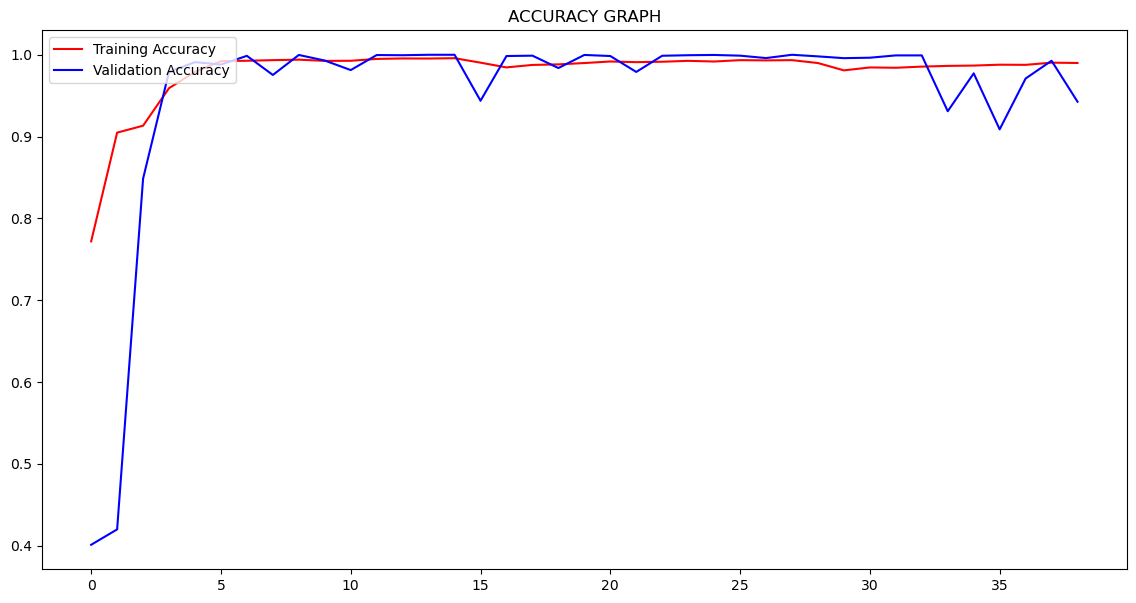

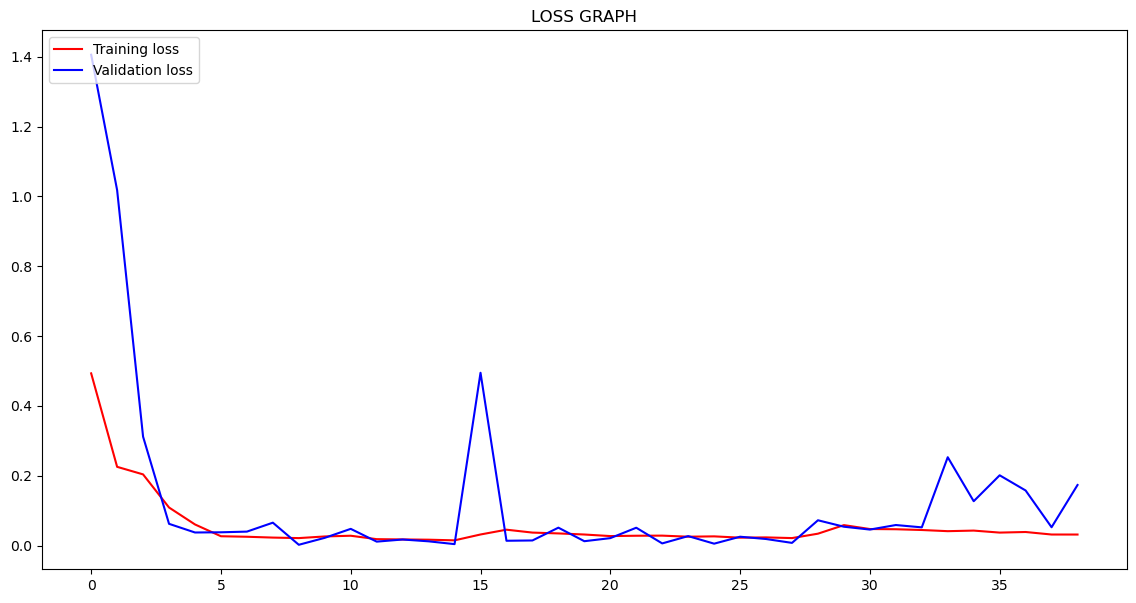

In [30]:
eval_graph(CNN_results_1)

In [31]:
Y_test1

22566    0
51319    0
2989     0
19604    0
56225    0
        ..
19008    0
12595    1
43588    0
36006    0
38170    0
Name: result, Length: 11507, dtype: int64

In [32]:
Y_test1

22566    0
51319    0
2989     0
19604    0
56225    0
        ..
19008    0
12595    1
43588    0
36006    0
38170    0
Name: result, Length: 11507, dtype: int64

360/360 [==============================] - 3s 7ms/step


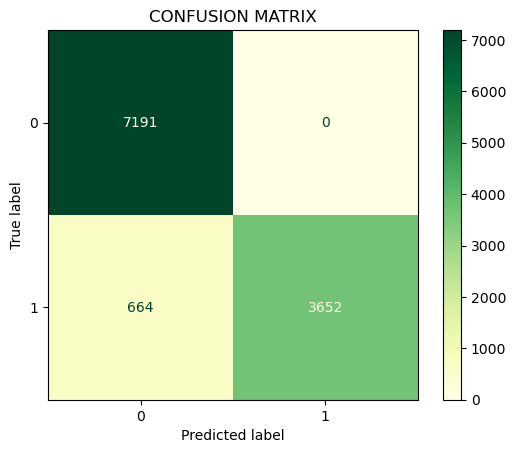

In [33]:
conf_matrix(X_test1,Y_test1,CNN_model1)

In [34]:
# CNN MODEL ON SECOND DATASET
CNN_model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

callbacks = [tf.keras.callbacks.ModelCheckpoint('CNN_MODEL_ON_NON_FEATURE_EXTRACTED.h5',verbose=1,save_best_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001,patience=30,verbose=1)]
CNN_results_2 = CNN_model2.fit(X_train2,Y_train2,validation_split=0.2,batch_size=128,epochs=200,callbacks=callbacks)

Epoch 1/200
288/288 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.7914
Epoch 1: val_loss improved from inf to 0.70366, saving model to CNN_MODEL_ON_NON_FEATURE_EXTRACTED.h5
288/288 [==============================] - 292s 997ms/step - loss: 0.4818 - accuracy: 0.7914 - val_loss: 0.7037 - val_accuracy: 0.4538
Epoch 2/200
288/288 [==============================] - ETA: 0s - loss: 0.3124 - accuracy: 0.8591
Epoch 2: val_loss improved from 0.70366 to 0.25473, saving model to CNN_MODEL_ON_NON_FEATURE_EXTRACTED.h5
288/288 [==============================] - 315s 1s/step - loss: 0.3124 - accuracy: 0.8591 - val_loss: 0.2547 - val_accuracy: 0.8927
Epoch 3/200
288/288 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.8804
Epoch 3: val_loss improved from 0.25473 to 0.22288, saving model to CNN_MODEL_ON_NON_FEATURE_EXTRACTED.h5
288/288 [==============================] - 281s 975ms/step - loss: 0.2734 - accuracy: 0.8804 - val_loss: 0.2229 - val_accuracy: 

Epoch 29/200
288/288 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9368
Epoch 29: val_loss did not improve from 0.18784
288/288 [==============================] - 282s 980ms/step - loss: 0.1359 - accuracy: 0.9368 - val_loss: 0.2061 - val_accuracy: 0.9180
Epoch 30/200
288/288 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9377
Epoch 30: val_loss did not improve from 0.18784
288/288 [==============================] - 271s 938ms/step - loss: 0.1334 - accuracy: 0.9377 - val_loss: 0.2226 - val_accuracy: 0.9207
Epoch 31/200
288/288 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9384
Epoch 31: val_loss did not improve from 0.18784
288/288 [==============================] - 304s 1s/step - loss: 0.1344 - accuracy: 0.9384 - val_loss: 0.2656 - val_accuracy: 0.8981
Epoch 32/200
288/288 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9382
Epoch 32: val_loss did not improve from 0.18784
288/288 [=====

In [35]:
CNN_model2.evaluate(X_test2,Y_test2,verbose = 1)

360/360 [==============================] - 20s 55ms/step - loss: 0.2540 - accuracy: 0.9141


[0.2540035843849182, 0.9141392111778259]

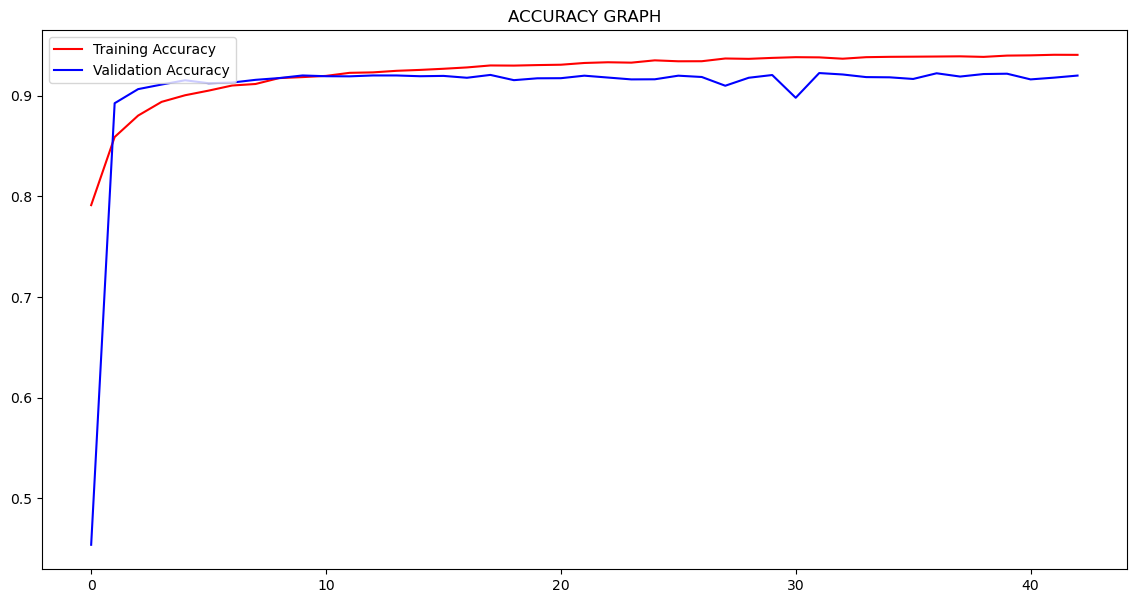

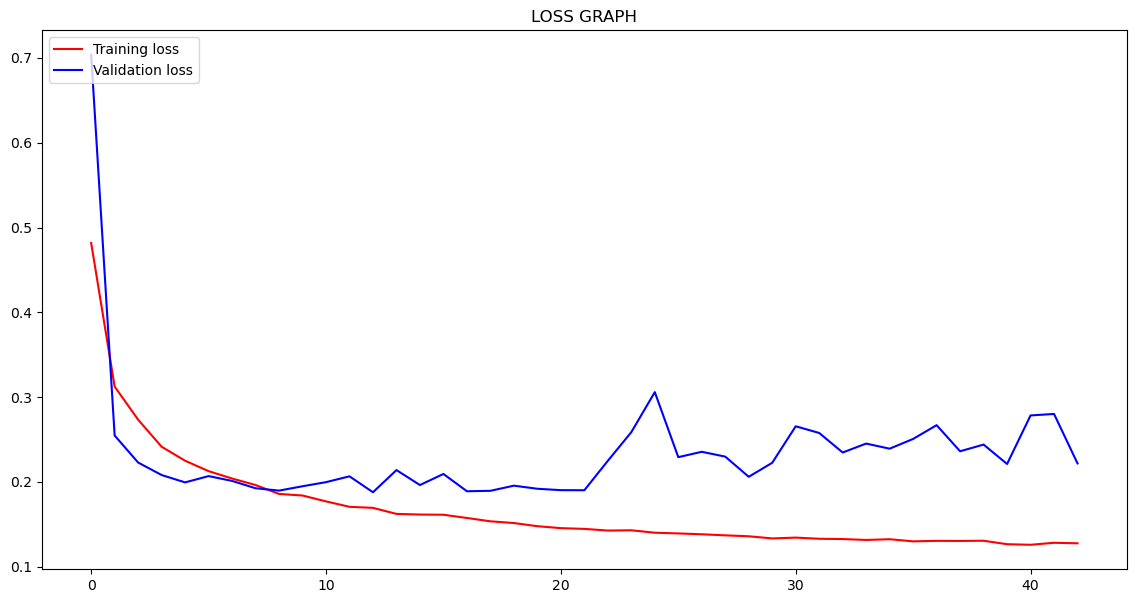

360/360 [==============================] - 18s 47ms/step


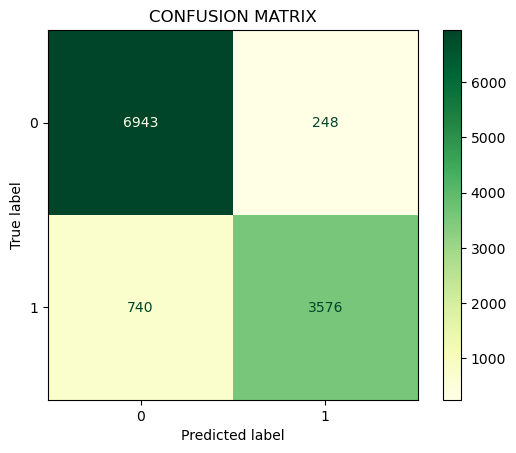

In [36]:
eval_graph(CNN_results_2)
conf_matrix(X_test2,Y_test2,CNN_model2)


In [37]:
# CNN LSTM MODEL
def CNN_LSTM(input_size):
    model = keras.Sequential()
    model.add(layers.Input(input_size))
    model.add(layers.Conv1D(filters = 16,kernel_size = 3,activation = 'relu',padding = 'same'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size = 2,padding = 'same'))
    model.add(layers.Conv1D(filters = 32,kernel_size = 3,activation = 'relu',padding = 'same'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size = 2,padding = 'same'))
    model.add(layers.Conv1D(filters = 64,kernel_size = 3,activation = 'relu',padding = 'same'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size = 2,padding = 'same'))
    model.add(layers.Conv1D(filters = 128,kernel_size = 3,activation = 'relu',padding = 'same'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size = 2,padding = 'same'))
    model.add(layers.Conv1D(filters = 256,kernel_size = 3,activation = 'relu',padding = 'same'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.LSTM(128,return_sequences=True))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128,activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1,activation = 'sigmoid'))
    
    return model

CNN_LSTM_model1 = CNN_LSTM(input_size1)
CNN_LSTM_model1.summary()
CNN_LSTM_model2 = CNN_LSTM(input_size2)    
CNN_LSTM_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 37, 16)            64        
                                                                 
 dropout_14 (Dropout)        (None, 37, 16)            0         
                                                                 
 batch_normalization_10 (Bat  (None, 37, 16)           64        
 chNormalization)                                                
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 19, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 19, 32)            1568      
                                                                 
 dropout_15 (Dropout)        (None, 19, 32)           

                                                                 
 dense_7 (Dense)             (None, 128)               1032320   
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,379,169
Trainable params: 1,378,177
Non-trainable params: 992
_________________________________________________________________


In [38]:
# CNN_LSTM MODEL ON FIRST DATASET
CNN_LSTM_model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

callbacks = [tf.keras.callbacks.ModelCheckpoint('CNN_LSTM_MODEL_ON_FEATURE_EXTRACTED.h5',verbose=1,save_best_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001,patience=30,verbose=1)]
CNN_LSTM_results_1 = CNN_LSTM_model1.fit(X_train1,Y_train1,validation_split=0.2,batch_size=128,epochs=200,callbacks=callbacks)

Epoch 1/200
288/288 [==============================] - ETA: 0s - loss: 0.3253 - accuracy: 0.8521
Epoch 1: val_loss improved from inf to 1.04108, saving model to CNN_LSTM_MODEL_ON_FEATURE_EXTRACTED.h5
288/288 [==============================] - 40s 104ms/step - loss: 0.3253 - accuracy: 0.8521 - val_loss: 1.0411 - val_accuracy: 0.4181
Epoch 2/200
288/288 [==============================] - ETA: 0s - loss: 0.1074 - accuracy: 0.9615
Epoch 2: val_loss improved from 1.04108 to 0.17215, saving model to CNN_LSTM_MODEL_ON_FEATURE_EXTRACTED.h5
288/288 [==============================] - 35s 121ms/step - loss: 0.1074 - accuracy: 0.9615 - val_loss: 0.1721 - val_accuracy: 0.9677
Epoch 3/200
288/288 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9724
Epoch 3: val_loss improved from 0.17215 to 0.01551, saving model to CNN_LSTM_MODEL_ON_FEATURE_EXTRACTED.h5
288/288 [==============================] - 34s 118ms/step - loss: 0.0791 - accuracy: 0.9724 - val_loss: 0.0155 - val_accurac

360/360 [==============================] - 4s 12ms/step - loss: 0.0898 - accuracy: 0.9957


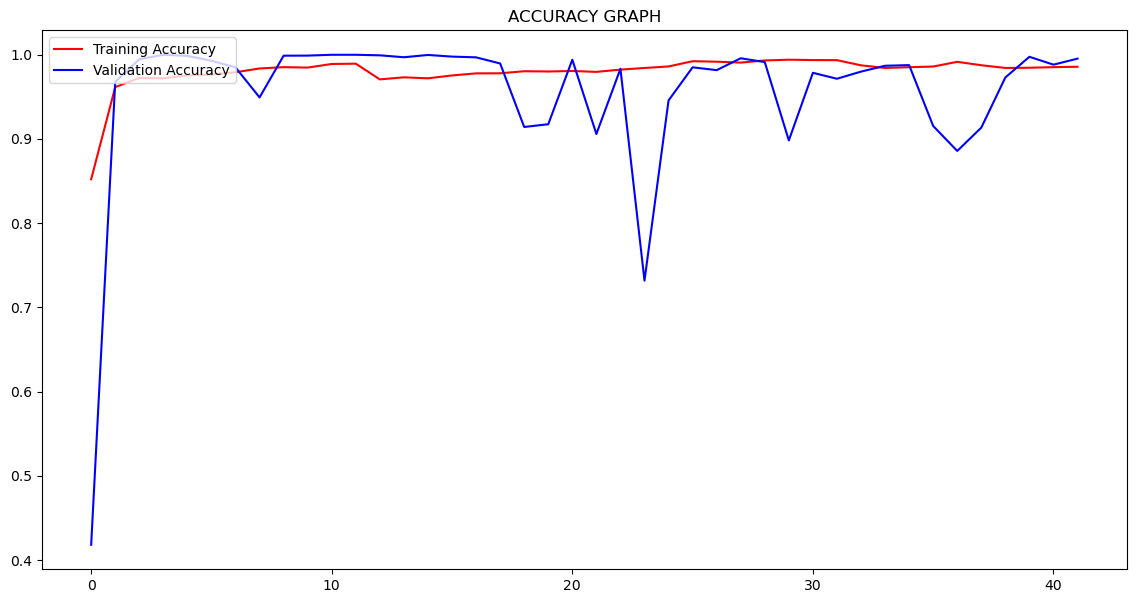

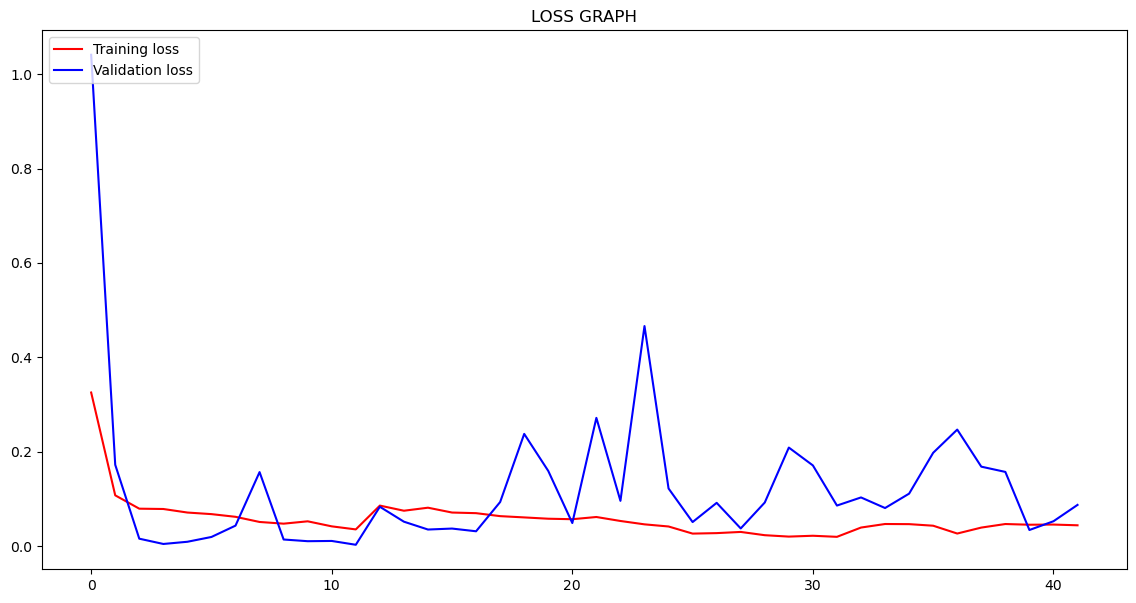

360/360 [==============================] - 5s 10ms/step


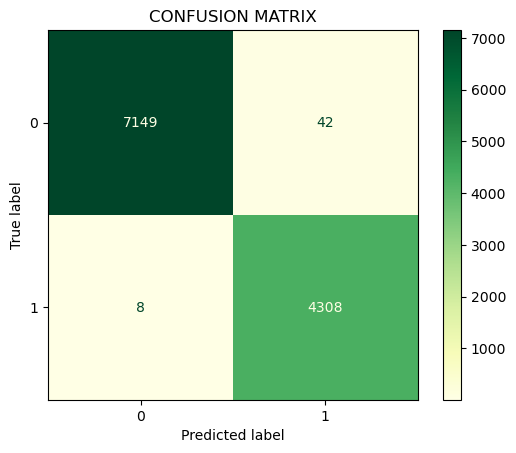

In [39]:
CNN_LSTM_model1.evaluate(X_test1,Y_test1)
eval_graph(CNN_LSTM_results_1)
conf_matrix(X_test1,Y_test1,CNN_LSTM_model1)

In [40]:
# CNN_LSTM MODEL ON SECOND DATASET
CNN_LSTM_model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

callbacks = [tf.keras.callbacks.ModelCheckpoint('CNN_LSTM_MODEL_ON_NON_FEATURE_EXTRACTED.h5',verbose=1,save_best_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001,patience=30,verbose=1)]
CNN_LSTM_results_2 = CNN_LSTM_model2.fit(X_train2,Y_train2,validation_split=0.2,batch_size=128,epochs=200,callbacks=callbacks)

Epoch 1/200
288/288 [==============================] - ETA: 0s - loss: 0.4218 - accuracy: 0.7957
Epoch 1: val_loss improved from inf to 0.69801, saving model to CNN_LSTM_MODEL_ON_NON_FEATURE_EXTRACTED.h5
288/288 [==============================] - 445s 2s/step - loss: 0.4218 - accuracy: 0.7957 - val_loss: 0.6980 - val_accuracy: 0.5222
Epoch 2/200
288/288 [==============================] - ETA: 0s - loss: 0.3004 - accuracy: 0.8652
Epoch 2: val_loss improved from 0.69801 to 0.25904, saving model to CNN_LSTM_MODEL_ON_NON_FEATURE_EXTRACTED.h5
288/288 [==============================] - 412s 1s/step - loss: 0.3004 - accuracy: 0.8652 - val_loss: 0.2590 - val_accuracy: 0.8867
Epoch 3/200
288/288 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.8878
Epoch 3: val_loss improved from 0.25904 to 0.22203, saving model to CNN_LSTM_MODEL_ON_NON_FEATURE_EXTRACTED.h5
288/288 [==============================] - 460s 2s/step - loss: 0.2597 - accuracy: 0.8878 - val_loss: 0.2220 - val_a

288/288 [==============================] - 245s 850ms/step - loss: 0.1275 - accuracy: 0.9400 - val_loss: 0.2115 - val_accuracy: 0.9195
Epoch 29/200
288/288 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9389
Epoch 29: val_loss did not improve from 0.18791
288/288 [==============================] - 226s 787ms/step - loss: 0.1285 - accuracy: 0.9389 - val_loss: 0.2218 - val_accuracy: 0.9227
Epoch 30/200
288/288 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9392
Epoch 30: val_loss did not improve from 0.18791
288/288 [==============================] - 232s 805ms/step - loss: 0.1263 - accuracy: 0.9392 - val_loss: 0.2109 - val_accuracy: 0.9223
Epoch 31/200
288/288 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9413
Epoch 31: val_loss did not improve from 0.18791
288/288 [==============================] - 225s 782ms/step - loss: 0.1239 - accuracy: 0.9413 - val_loss: 0.2165 - val_accuracy: 0.9200
Epoch 32/200
288/288 [

360/360 [==============================] - 27s 74ms/step - loss: 0.2546 - accuracy: 0.9157


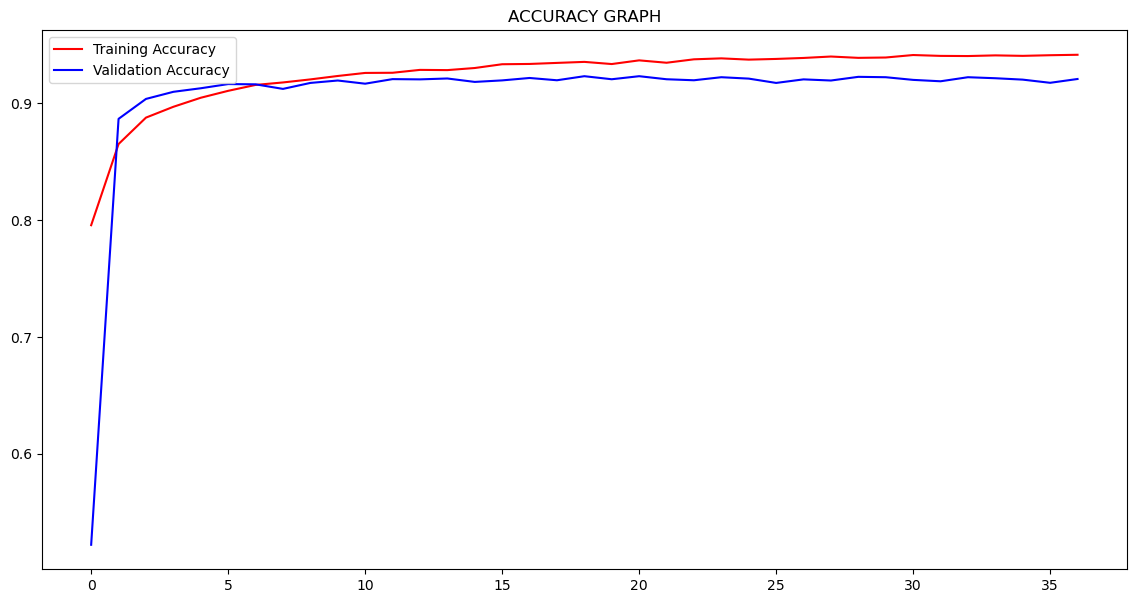

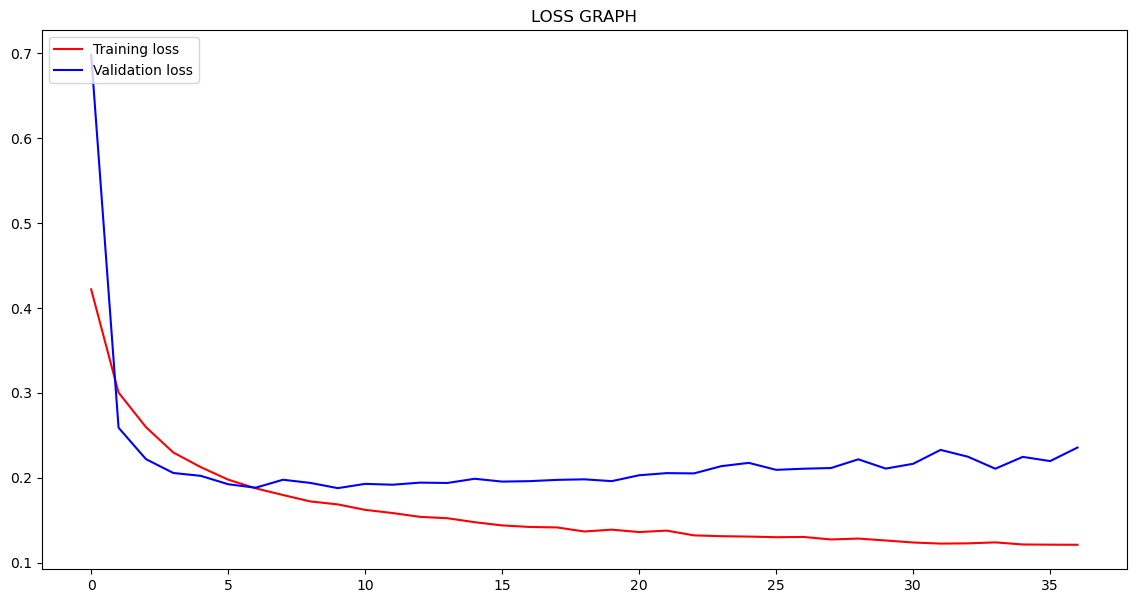

360/360 [==============================] - 21s 55ms/step


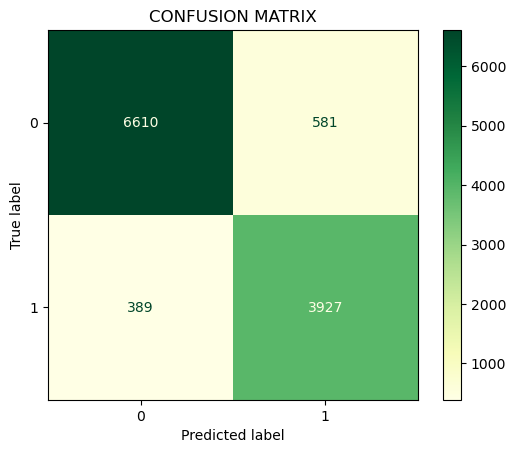

In [41]:
CNN_LSTM_model2.evaluate(X_test2,Y_test2)
eval_graph(CNN_LSTM_results_2)
conf_matrix(X_test2,Y_test2,CNN_LSTM_model2)